In [1]:
%matplotlib inline

# Gaussian process models for stellar variability

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.2.0


When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

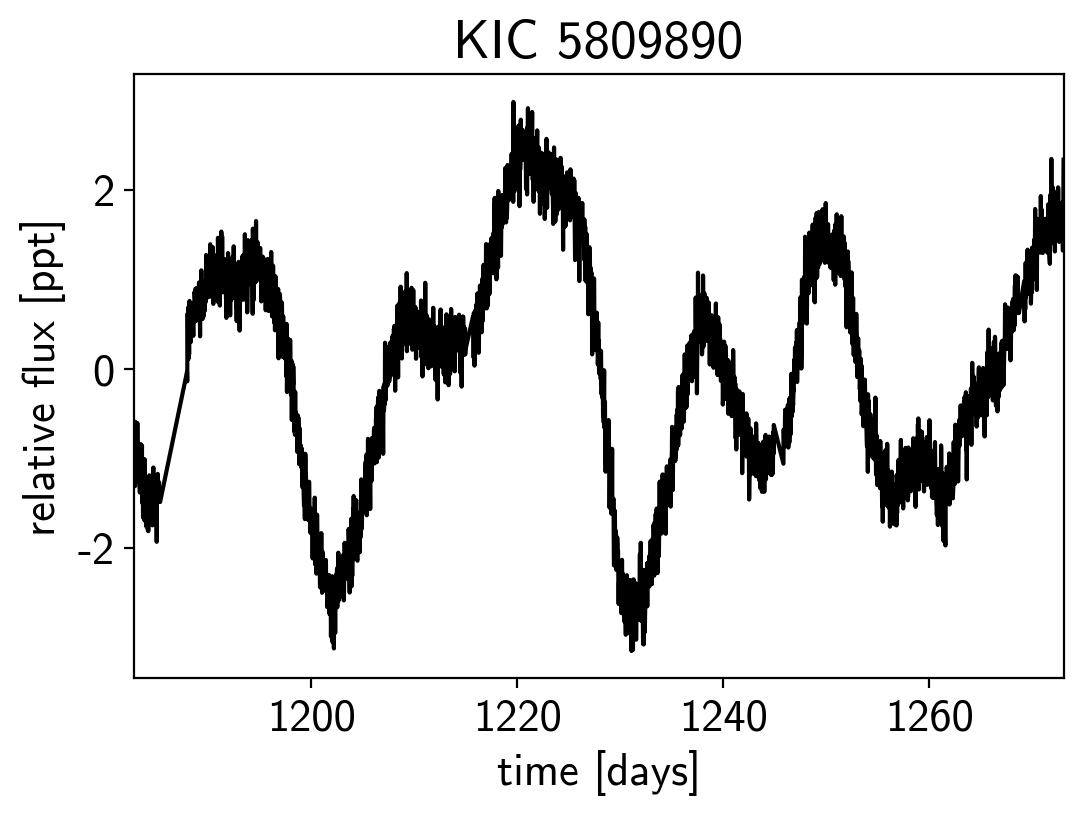

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

url = "https://archive.stsci.edu/missions/kepler/lightcurves/0058/005809890/kplr005809890-2012179063303_llc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    hdr = hdus[1].header
    
# Work out the exposure time
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0    

x = data["TIME"]
y = data["PDCSAP_FLUX"]
yerr = data["PDCSAP_FLUX_ERR"]
m = (data["SAP_QUALITY"] == 0) & np.isfinite(x) & np.isfinite(y)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

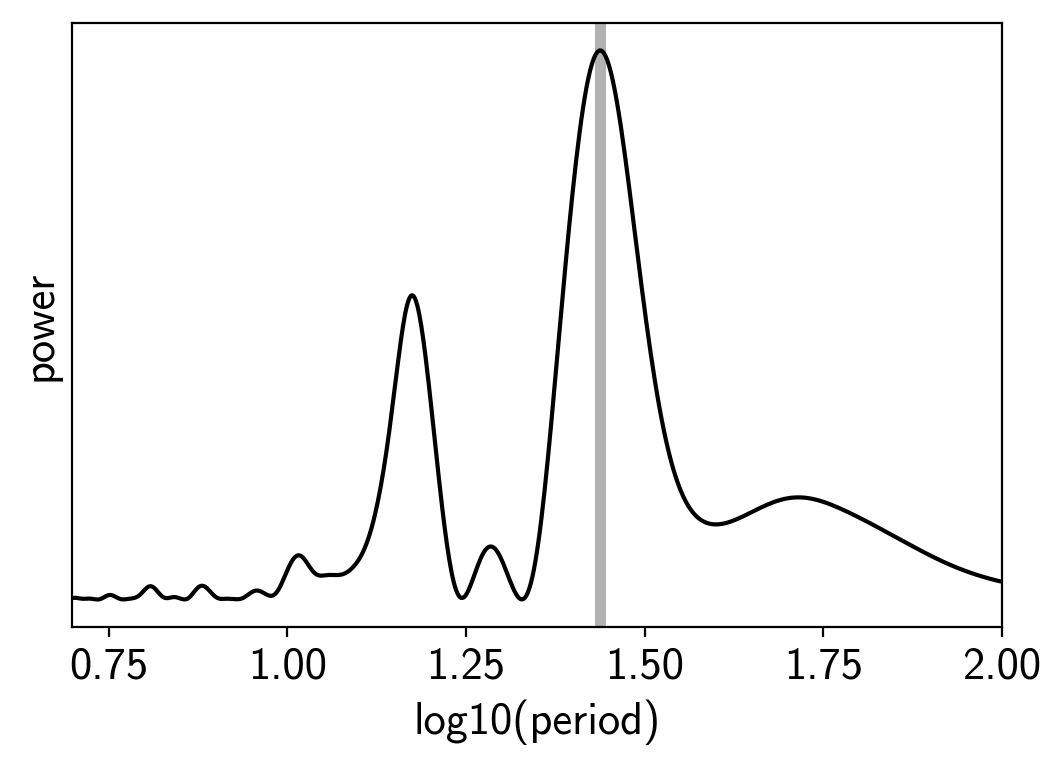

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)
    
    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr)), sd=5.0)
    
    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = pm.Uniform("mix", lower=0, upper=1.0)
    
    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))
    
    # Set up the Gaussian Process model
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdeltaQ,
        mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2), J=4)
    
    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())
    
    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logperiod_interval__', 'logamp', 'logs2', 'mean']


message: Optimization terminated successfully.
logp: 263.10222197490816 -> 692.0354844282873


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

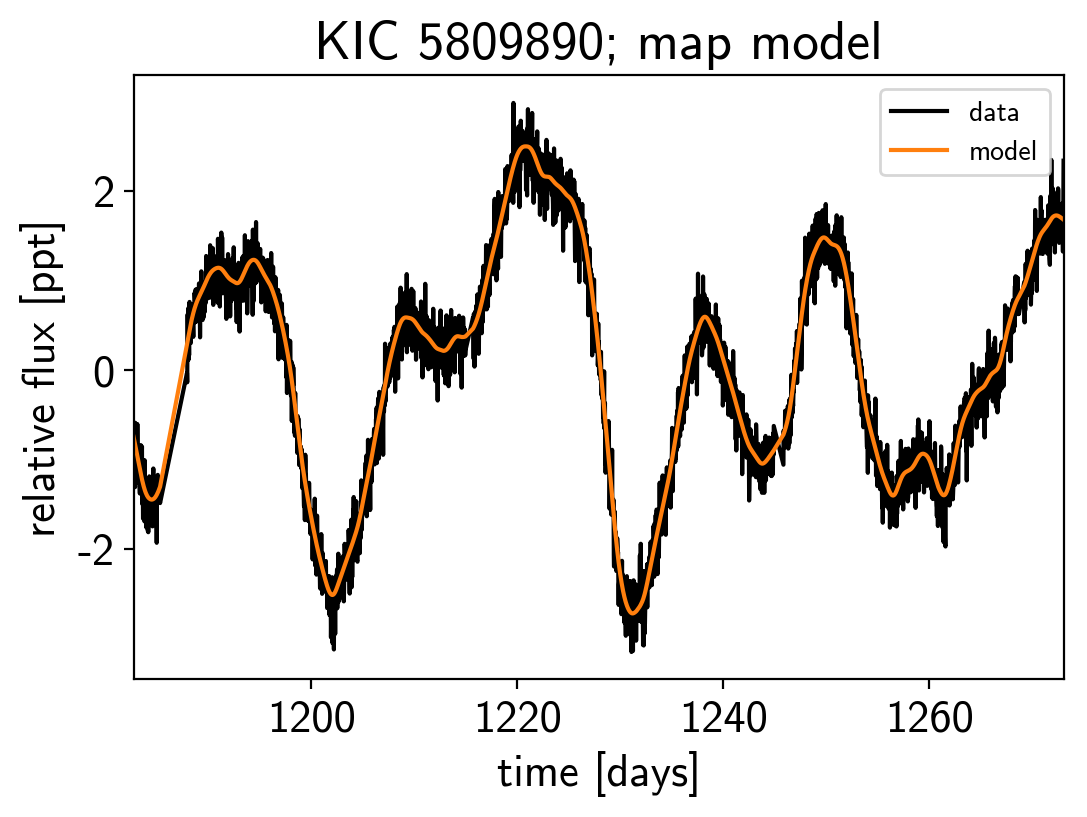

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using a :class:`exoplanet.PyMC3Sampler`.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 7/308 [00:00<00:08, 37.38draws/s]

Sampling 4 chains:   3%|▎         | 10/308 [00:00<00:17, 16.82draws/s]

Sampling 4 chains:   4%|▍         | 12/308 [00:00<00:19, 15.41draws/s]

Sampling 4 chains:   5%|▍         | 14/308 [00:00<00:18, 15.81draws/s]

Sampling 4 chains:   5%|▌         | 16/308 [00:01<00:27, 10.79draws/s]

Sampling 4 chains:   6%|▌         | 19/308 [00:01<00:22, 12.78draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:01<00:20, 14.06draws/s]

Sampling 4 chains:   7%|▋         | 23/308 [00:01<00:23, 12.28draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:02<00:34,  8.18draws/s]

Sampling 4 chains:   9%|▉         | 28/308 [00:02<00:27, 10.31draws/s]

Sampling 4 chains:  10%|▉         | 30/308 [00:02<00:23, 11.70draws/s]

Sampling 4 chains:  11%|█▏        | 35/308 [00:02<00:18, 14.83draws/s]

Sampling 4 chains:  12%|█▏        | 38/308 [00:02<00:15, 17.24draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:02<00:17, 15.26draws/s]

Sampling 4 chains:  14%|█▍        | 44/308 [00:02<00:15, 17.25draws/s]

Sampling 4 chains:  15%|█▌        | 47/308 [00:03<00:13, 19.13draws/s]

Sampling 4 chains:  16%|█▌        | 50/308 [00:03<00:12, 20.07draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:03<00:14, 17.77draws/s]

Sampling 4 chains:  18%|█▊        | 56/308 [00:03<00:14, 17.96draws/s]

Sampling 4 chains:  19%|█▉        | 59/308 [00:03<00:12, 19.34draws/s]

Sampling 4 chains:  21%|██        | 64/308 [00:03<00:10, 22.65draws/s]

Sampling 4 chains:  22%|██▏       | 67/308 [00:03<00:09, 24.28draws/s]

Sampling 4 chains:  23%|██▎       | 70/308 [00:04<00:12, 18.71draws/s]

Sampling 4 chains:  24%|██▍       | 74/308 [00:04<00:11, 20.73draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:04<00:10, 22.66draws/s]

Sampling 4 chains:  26%|██▋       | 81/308 [00:04<00:09, 22.94draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:04<00:10, 20.62draws/s]

Sampling 4 chains:  29%|██▊       | 88/308 [00:05<00:11, 18.36draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:05<00:11, 18.25draws/s]

Sampling 4 chains:  31%|███       | 94/308 [00:05<00:11, 18.90draws/s]

Sampling 4 chains:  31%|███       | 96/308 [00:05<00:12, 16.98draws/s]

Sampling 4 chains:  32%|███▏      | 98/308 [00:05<00:16, 12.59draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:05<00:19, 10.63draws/s]

Sampling 4 chains:  33%|███▎      | 102/308 [00:06<00:18, 11.43draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:06<00:13, 15.07draws/s]

Sampling 4 chains:  36%|███▌      | 111/308 [00:06<00:12, 15.63draws/s]

Sampling 4 chains:  37%|███▋      | 114/308 [00:06<00:11, 17.23draws/s]

Sampling 4 chains:  38%|███▊      | 118/308 [00:06<00:12, 15.58draws/s]

Sampling 4 chains:  39%|███▉      | 121/308 [00:06<00:10, 17.71draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:07<00:11, 15.50draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:07<00:13, 13.00draws/s]

Sampling 4 chains:  42%|████▏     | 130/308 [00:07<00:13, 12.79draws/s]

Sampling 4 chains:  44%|████▍     | 135/308 [00:07<00:11, 14.99draws/s]

Sampling 4 chains:  45%|████▍     | 138/308 [00:08<00:11, 14.32draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:08<00:09, 16.70draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [00:08<00:09, 16.59draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:08<00:10, 15.42draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:08<00:08, 18.31draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [00:09<00:08, 17.80draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:09<00:07, 19.61draws/s]

Sampling 4 chains:  52%|█████▏    | 160/308 [00:09<00:08, 18.40draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [00:09<00:07, 19.23draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:09<00:08, 16.33draws/s]

Sampling 4 chains:  55%|█████▍    | 168/308 [00:09<00:09, 14.70draws/s]

Sampling 4 chains:  55%|█████▌    | 170/308 [00:10<00:09, 13.90draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:10<00:08, 16.30draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:10<00:09, 13.91draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [00:10<00:08, 16.06draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [00:10<00:06, 18.87draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [00:10<00:05, 22.37draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [00:11<00:07, 16.13draws/s]

Sampling 4 chains:  62%|██████▏   | 192/308 [00:11<00:06, 18.11draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [00:11<00:06, 17.74draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [00:11<00:05, 19.72draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:11<00:05, 20.52draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [00:11<00:04, 22.20draws/s]

Sampling 4 chains:  68%|██████▊   | 208/308 [00:12<00:06, 15.12draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [00:12<00:06, 15.39draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [00:12<00:04, 18.74draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:12<00:04, 18.63draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [00:12<00:04, 18.95draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:12<00:03, 23.27draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:12<00:03, 23.25draws/s]

Sampling 4 chains:  76%|███████▌  | 233/308 [00:13<00:03, 21.94draws/s]

Sampling 4 chains:  77%|███████▋  | 236/308 [00:13<00:03, 19.29draws/s]

Sampling 4 chains:  78%|███████▊  | 239/308 [00:13<00:03, 21.51draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:13<00:02, 23.35draws/s]

Sampling 4 chains:  80%|███████▉  | 245/308 [00:13<00:03, 19.62draws/s]

Sampling 4 chains:  81%|████████  | 248/308 [00:13<00:03, 17.24draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:14<00:04, 13.19draws/s]

Sampling 4 chains:  82%|████████▏ | 253/308 [00:14<00:04, 13.06draws/s]

Sampling 4 chains:  83%|████████▎ | 255/308 [00:14<00:03, 13.35draws/s]

Sampling 4 chains:  84%|████████▍ | 259/308 [00:14<00:03, 14.83draws/s]

Sampling 4 chains:  85%|████████▍ | 261/308 [00:14<00:02, 16.04draws/s]

Sampling 4 chains:  85%|████████▌ | 263/308 [00:15<00:03, 13.61draws/s]

Sampling 4 chains:  87%|████████▋ | 267/308 [00:15<00:02, 15.25draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:15<00:02, 17.68draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [00:15<00:01, 19.16draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [00:15<00:01, 21.84draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [00:16<00:02, 11.41draws/s]

Sampling 4 chains:  92%|█████████▏| 283/308 [00:16<00:01, 13.05draws/s]

Sampling 4 chains:  93%|█████████▎| 287/308 [00:16<00:01, 16.23draws/s]

Sampling 4 chains:  94%|█████████▍| 291/308 [00:16<00:00, 17.71draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:17<00:01,  9.61draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:17<00:01,  6.40draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:18<00:01,  6.19draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [00:18<00:01,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:19<00:01,  3.78draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:19<00:00,  4.91draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:20<00:01,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:20<00:00,  2.95draws/s]

Sampling 4 chains: 100%|█████████▉| 307/308 [00:21<00:00,  2.43draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:21<00:00,  2.28draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:   9%|▉         | 10/108 [00:00<00:01, 62.92draws/s]

Sampling 4 chains:  12%|█▏        | 13/108 [00:00<00:04, 22.46draws/s]

Sampling 4 chains:  14%|█▍        | 15/108 [00:00<00:05, 16.85draws/s]

Sampling 4 chains:  17%|█▋        | 18/108 [00:00<00:05, 17.84draws/s]

Sampling 4 chains:  19%|█▊        | 20/108 [00:01<00:06, 13.51draws/s]

Sampling 4 chains:  20%|██        | 22/108 [00:01<00:07, 11.25draws/s]

Sampling 4 chains:  23%|██▎       | 25/108 [00:01<00:06, 12.76draws/s]

Sampling 4 chains:  27%|██▋       | 29/108 [00:01<00:05, 15.02draws/s]

Sampling 4 chains:  32%|███▏      | 35/108 [00:01<00:03, 19.11draws/s]

Sampling 4 chains:  36%|███▌      | 39/108 [00:01<00:03, 22.63draws/s]

Sampling 4 chains:  42%|████▏     | 45/108 [00:02<00:02, 25.23draws/s]

Sampling 4 chains:  45%|████▌     | 49/108 [00:02<00:02, 28.34draws/s]

Sampling 4 chains:  49%|████▉     | 53/108 [00:02<00:02, 23.57draws/s]

Sampling 4 chains:  54%|█████▎    | 58/108 [00:02<00:01, 27.17draws/s]

Sampling 4 chains:  57%|█████▋    | 62/108 [00:02<00:02, 22.88draws/s]

Sampling 4 chains:  60%|██████    | 65/108 [00:02<00:01, 23.48draws/s]

Sampling 4 chains:  63%|██████▎   | 68/108 [00:02<00:01, 23.35draws/s]

Sampling 4 chains:  68%|██████▊   | 73/108 [00:03<00:01, 26.61draws/s]

Sampling 4 chains:  72%|███████▏  | 78/108 [00:03<00:01, 27.52draws/s]

Sampling 4 chains:  76%|███████▌  | 82/108 [00:03<00:00, 30.06draws/s]

Sampling 4 chains:  80%|███████▉  | 86/108 [00:03<00:00, 30.45draws/s]

Sampling 4 chains:  83%|████████▎ | 90/108 [00:03<00:00, 31.27draws/s]

Sampling 4 chains:  87%|████████▋ | 94/108 [00:03<00:00, 32.86draws/s]

Sampling 4 chains:  91%|█████████ | 98/108 [00:04<00:00, 20.72draws/s]

Sampling 4 chains:  94%|█████████▎| 101/108 [00:04<00:00, 11.21draws/s]

Sampling 4 chains:  96%|█████████▋| 104/108 [00:04<00:00, 12.09draws/s]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:04<00:00, 13.17draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:05<00:00, 21.51draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 7/208 [00:00<00:02, 68.92draws/s]

Sampling 4 chains:   9%|▊         | 18/208 [00:00<00:02, 75.63draws/s]

Sampling 4 chains:  13%|█▎        | 28/208 [00:00<00:02, 80.77draws/s]

Sampling 4 chains:  18%|█▊        | 37/208 [00:00<00:02, 82.81draws/s]

Sampling 4 chains:  21%|██        | 44/208 [00:00<00:02, 57.97draws/s]

Sampling 4 chains:  24%|██▍       | 50/208 [00:00<00:03, 49.38draws/s]

Sampling 4 chains:  27%|██▋       | 56/208 [00:00<00:03, 49.00draws/s]

Sampling 4 chains:  30%|██▉       | 62/208 [00:01<00:02, 49.59draws/s]

Sampling 4 chains:  33%|███▎      | 69/208 [00:01<00:02, 53.97draws/s]

Sampling 4 chains:  37%|███▋      | 76/208 [00:01<00:02, 57.66draws/s]

Sampling 4 chains:  41%|████      | 85/208 [00:01<00:01, 61.60draws/s]

Sampling 4 chains:  44%|████▍     | 92/208 [00:01<00:01, 59.48draws/s]

Sampling 4 chains:  48%|████▊     | 99/208 [00:01<00:01, 57.41draws/s]

Sampling 4 chains:  51%|█████▏    | 107/208 [00:01<00:01, 59.57draws/s]

Sampling 4 chains:  55%|█████▌    | 115/208 [00:01<00:01, 64.06draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:01<00:01, 64.56draws/s]

Sampling 4 chains:  62%|██████▏   | 129/208 [00:02<00:01, 62.15draws/s]

Sampling 4 chains:  65%|██████▌   | 136/208 [00:02<00:01, 59.40draws/s]

Sampling 4 chains:  69%|██████▉   | 143/208 [00:02<00:01, 58.52draws/s]

Sampling 4 chains:  72%|███████▏  | 149/208 [00:02<00:01, 58.45draws/s]

Sampling 4 chains:  75%|███████▍  | 155/208 [00:02<00:00, 58.40draws/s]

Sampling 4 chains:  78%|███████▊  | 163/208 [00:02<00:00, 59.86draws/s]

Sampling 4 chains:  82%|████████▏ | 171/208 [00:02<00:00, 63.48draws/s]

Sampling 4 chains:  86%|████████▌ | 179/208 [00:02<00:00, 63.44draws/s]

Sampling 4 chains:  90%|█████████ | 188/208 [00:03<00:00, 67.99draws/s]

Sampling 4 chains:  95%|█████████▍| 197/208 [00:03<00:00, 73.29draws/s]

Sampling 4 chains:  99%|█████████▊| 205/208 [00:03<00:00, 57.78draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:03<00:00, 60.52draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 9/408 [00:00<00:04, 83.77draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:00<00:04, 83.99draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:04, 78.58draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:04, 78.80draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:00<00:05, 72.99draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:00<00:04, 75.50draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:00<00:05, 59.95draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:00<00:06, 52.71draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:01<00:06, 51.55draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:01<00:06, 52.07draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:01<00:06, 53.89draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:01<00:06, 52.14draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:01<00:05, 53.26draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:01<00:05, 54.78draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:01<00:06, 45.14draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:01<00:06, 46.32draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:02<00:05, 50.03draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:02<00:05, 52.53draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:02<00:05, 53.80draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:02<00:04, 55.22draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:02<00:04, 58.51draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:02<00:04, 61.41draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:02<00:03, 65.67draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:02<00:03, 61.71draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:03<00:03, 69.51draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:03<00:03, 67.45draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:03<00:03, 66.51draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:03<00:03, 66.33draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:03<00:03, 65.11draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:03<00:02, 63.79draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:03<00:02, 72.53draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:03<00:02, 65.59draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:03<00:02, 71.24draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:04<00:02, 72.85draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:04<00:01, 76.73draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:04<00:01, 77.02draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:04<00:01, 70.73draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:04<00:01, 66.13draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:04<00:01, 66.78draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:04<00:01, 73.72draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:04<00:01, 72.51draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:04<00:01, 74.35draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:05<00:01, 76.06draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:05<00:01, 64.60draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:05<00:01, 55.40draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:05<00:01, 48.32draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:05<00:01, 48.19draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:05<00:00, 48.11draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:05<00:00, 50.91draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:06<00:00, 55.88draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:06<00:00, 56.98draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:06<00:00, 55.00draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:06<00:00, 41.31draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [00:06<00:00, 40.48draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:06<00:00, 31.25draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:07<00:00, 58.23draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 7/808 [00:00<00:12, 65.08draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:11, 68.02draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:14, 55.87draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:14, 53.58draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:15, 51.48draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:14, 53.37draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:00<00:14, 51.79draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:14, 50.85draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:01<00:13, 53.99draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:01<00:14, 52.07draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:01<00:15, 46.65draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:01<00:18, 40.44draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:01<00:18, 38.50draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:01<00:17, 41.10draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:01<00:15, 46.55draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:01<00:16, 43.25draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:02<00:18, 37.95draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:02<00:17, 39.24draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:02<00:19, 35.22draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:02<00:18, 36.49draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:02<00:15, 43.01draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:02<00:16, 41.75draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:02<00:14, 45.38draws/s]

Sampling 4 chains:  18%|█▊        | 142/808 [00:03<00:13, 50.45draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:03<00:11, 57.46draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:03<00:10, 60.13draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:03<00:12, 53.09draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:03<00:11, 54.72draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:03<00:11, 53.48draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:03<00:11, 54.15draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:03<00:12, 49.44draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:03<00:11, 53.71draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:04<00:10, 59.08draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:04<00:09, 65.43draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:04<00:10, 56.52draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:04<00:11, 50.09draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:04<00:11, 52.18draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:04<00:10, 52.93draws/s]

Sampling 4 chains:  30%|███       | 245/808 [00:04<00:10, 51.83draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:05<00:11, 46.51draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:05<00:11, 49.77draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:05<00:09, 55.33draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:05<00:09, 57.96draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:05<00:08, 59.55draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:05<00:08, 62.95draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:05<00:07, 66.48draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:05<00:07, 67.41draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:05<00:07, 64.74draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:06<00:07, 61.24draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:06<00:08, 59.29draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:06<00:08, 55.01draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:06<00:08, 53.95draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:06<00:08, 56.18draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:06<00:07, 63.31draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:06<00:06, 66.68draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:06<00:06, 67.59draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:07<00:06, 70.51draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [00:07<00:06, 67.74draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:07<00:05, 69.34draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:07<00:05, 70.24draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [00:07<00:05, 68.49draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:07<00:05, 71.00draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:07<00:05, 70.40draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:07<00:05, 67.79draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:07<00:05, 70.29draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:08<00:04, 74.61draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:08<00:04, 80.04draws/s]

Sampling 4 chains:  59%|█████▉    | 480/808 [00:08<00:03, 84.97draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:08<00:03, 83.99draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:08<00:04, 75.85draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:08<00:03, 79.52draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:08<00:04, 70.27draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:08<00:04, 69.01draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:09<00:04, 67.26draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:09<00:04, 63.82draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:09<00:03, 66.34draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:09<00:03, 74.51draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:09<00:03, 70.27draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:09<00:03, 61.61draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:09<00:03, 67.57draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:09<00:03, 68.70draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:10<00:03, 67.60draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:10<00:02, 70.85draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:10<00:02, 73.16draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [00:10<00:02, 71.25draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:10<00:02, 75.21draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:10<00:02, 73.40draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:10<00:02, 70.62draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [00:10<00:02, 73.00draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [00:10<00:01, 70.85draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:11<00:01, 66.41draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:11<00:01, 67.16draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [00:11<00:01, 69.98draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:11<00:01, 70.26draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:11<00:01, 69.31draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:11<00:01, 72.81draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:11<00:01, 72.43draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:11<00:00, 73.99draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:12<00:00, 68.90draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:12<00:00, 67.12draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:12<00:00, 53.64draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:12<00:00, 48.96draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:12<00:00, 48.96draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:12<00:00, 43.49draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:13<00:00, 38.60draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:13<00:00, 25.79draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:13<00:00, 22.80draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:13<00:00, 19.54draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:13<00:00, 20.78draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:14<00:00, 19.97draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:14<00:00, 14.79draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:14<00:00, 12.65draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:14<00:00, 54.92draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 7/1608 [00:00<00:24, 66.36draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:00<00:23, 67.17draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:00<00:26, 59.07draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:00<00:26, 58.81draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:00<00:24, 63.85draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:00<00:27, 57.61draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:00<00:28, 54.14draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:00<00:28, 55.44draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:01<00:29, 52.73draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:01<00:32, 47.75draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:01<00:30, 50.23draws/s]

Sampling 4 chains:   5%|▍         | 76/1608 [00:01<00:29, 51.47draws/s]

Sampling 4 chains:   5%|▌         | 82/1608 [00:01<00:30, 50.55draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:01<00:29, 51.32draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:01<00:25, 58.65draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:01<00:23, 63.28draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:01<00:23, 64.35draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:02<00:24, 61.87draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:02<00:29, 50.32draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:02<00:27, 52.82draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:02<00:28, 51.55draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:02<00:28, 51.50draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:02<00:27, 53.73draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:02<00:26, 55.17draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:02<00:25, 55.77draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:03<00:27, 51.86draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:03<00:25, 55.88draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:03<00:25, 55.44draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:03<00:25, 55.96draws/s]

Sampling 4 chains:  12%|█▏        | 197/1608 [00:03<00:23, 58.84draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:03<00:23, 59.09draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:03<00:22, 60.99draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:03<00:23, 58.63draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:04<00:26, 52.43draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:04<00:23, 57.41draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:04<00:23, 57.40draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:04<00:22, 59.99draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:04<00:21, 62.52draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:04<00:21, 63.48draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:04<00:21, 61.47draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:04<00:20, 65.32draws/s]

Sampling 4 chains:  18%|█▊        | 284/1608 [00:04<00:21, 62.05draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:05<00:20, 64.65draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:05<00:21, 60.47draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:05<00:19, 65.55draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:05<00:19, 64.85draws/s]

Sampling 4 chains:  20%|██        | 322/1608 [00:05<00:20, 62.31draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [00:05<00:19, 65.57draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:05<00:19, 66.67draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:05<00:17, 71.62draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:05<00:17, 70.38draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:06<00:17, 70.99draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [00:06<00:18, 65.26draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:06<00:22, 54.62draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [00:06<00:21, 56.09draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:06<00:19, 60.85draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:06<00:18, 65.73draws/s]

Sampling 4 chains:  25%|██▌       | 410/1608 [00:06<00:17, 67.08draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [00:06<00:18, 65.82draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:07<00:18, 62.33draws/s]

Sampling 4 chains:  27%|██▋       | 432/1608 [00:07<00:18, 64.50draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:07<00:16, 71.05draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:07<00:17, 66.52draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [00:07<00:18, 63.37draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:07<00:18, 62.52draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:07<00:17, 63.32draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [00:07<00:17, 64.22draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:08<00:18, 61.51draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:08<00:16, 65.80draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:08<00:16, 68.07draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [00:08<00:15, 71.46draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:08<00:16, 67.78draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:08<00:14, 74.14draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [00:08<00:16, 65.27draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [00:08<00:16, 66.40draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [00:08<00:14, 71.13draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:09<00:14, 72.47draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:09<00:16, 62.55draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [00:09<00:17, 57.39draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [00:09<00:18, 55.26draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [00:09<00:17, 57.75draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [00:09<00:17, 58.34draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [00:09<00:17, 58.82draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [00:09<00:15, 62.60draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:10<00:15, 62.60draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [00:10<00:14, 67.61draws/s]

Sampling 4 chains:  40%|███▉      | 639/1608 [00:10<00:14, 68.15draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:10<00:14, 67.01draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [00:10<00:13, 71.46draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:10<00:13, 69.14draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [00:10<00:14, 65.83draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:10<00:12, 73.04draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [00:11<00:12, 76.18draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [00:11<00:11, 78.62draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [00:11<00:11, 77.11draws/s]

Sampling 4 chains:  45%|████▍     | 718/1608 [00:11<00:11, 76.89draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [00:11<00:12, 72.71draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [00:11<00:12, 67.33draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [00:11<00:13, 64.26draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [00:11<00:13, 65.40draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [00:11<00:12, 66.41draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [00:12<00:12, 67.28draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:12<00:13, 63.04draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [00:12<00:13, 61.92draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [00:12<00:13, 61.69draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [00:12<00:12, 64.76draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [00:12<00:11, 67.85draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [00:12<00:11, 70.51draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [00:12<00:11, 68.27draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [00:13<00:11, 65.33draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [00:13<00:11, 66.25draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [00:13<00:12, 63.21draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [00:13<00:11, 68.60draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:13<00:10, 68.64draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [00:13<00:10, 69.91draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [00:13<00:09, 74.86draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [00:13<00:10, 70.99draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [00:13<00:09, 76.77draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [00:14<00:09, 73.95draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [00:14<00:09, 74.43draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [00:14<00:10, 64.31draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [00:14<00:10, 65.49draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [00:14<00:09, 70.84draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [00:14<00:09, 71.42draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [00:14<00:08, 74.70draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [00:14<00:08, 78.26draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [00:15<00:08, 75.29draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [00:15<00:08, 72.13draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [00:15<00:09, 63.37draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [00:15<00:10, 60.65draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [00:15<00:10, 60.78draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [00:15<00:09, 65.03draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [00:15<00:09, 63.06draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [00:15<00:08, 66.31draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [00:15<00:08, 67.69draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [00:16<00:07, 72.62draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [00:16<00:07, 70.59draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [00:16<00:07, 74.62draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [00:16<00:06, 77.60draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [00:16<00:06, 77.74draws/s]

Sampling 4 chains:  67%|██████▋   | 1083/1608 [00:16<00:07, 72.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [00:16<00:07, 71.49draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [00:16<00:06, 73.59draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [00:17<00:07, 67.51draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [00:17<00:06, 74.48draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [00:17<00:06, 71.62draws/s]

Sampling 4 chains:  70%|███████   | 1133/1608 [00:17<00:06, 68.23draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [00:17<00:07, 60.28draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [00:17<00:08, 57.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [00:17<00:07, 61.30draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [00:17<00:06, 67.67draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [00:18<00:05, 72.38draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [00:18<00:05, 73.73draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [00:18<00:05, 76.34draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [00:18<00:04, 83.06draws/s]

Sampling 4 chains:  76%|███████▌  | 1218/1608 [00:18<00:04, 88.62draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [00:18<00:04, 80.41draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [00:18<00:04, 82.54draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [00:18<00:04, 81.83draws/s]

Sampling 4 chains:  78%|███████▊  | 1257/1608 [00:18<00:04, 84.11draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [00:19<00:03, 89.75draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [00:19<00:03, 89.40draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [00:19<00:03, 87.10draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [00:19<00:03, 86.41draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [00:19<00:03, 86.92draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [00:19<00:03, 87.11draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [00:19<00:03, 90.22draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [00:19<00:03, 79.90draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [00:19<00:03, 82.50draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [00:20<00:03, 82.49draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [00:20<00:03, 75.30draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [00:20<00:02, 78.61draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [00:20<00:03, 69.59draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [00:20<00:03, 71.47draws/s]

Sampling 4 chains:  87%|████████▋ | 1398/1608 [00:20<00:03, 68.90draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [00:20<00:02, 71.72draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [00:20<00:02, 69.83draws/s]

Sampling 4 chains:  89%|████████▊ | 1425/1608 [00:21<00:02, 73.00draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [00:21<00:02, 78.89draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [00:21<00:02, 77.24draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [00:21<00:01, 85.76draws/s]

Sampling 4 chains:  91%|█████████ | 1465/1608 [00:21<00:01, 83.54draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [00:21<00:01, 80.28draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [00:21<00:01, 78.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [00:21<00:01, 75.93draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [00:22<00:01, 71.48draws/s]

Sampling 4 chains:  94%|█████████▍| 1508/1608 [00:22<00:01, 62.24draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [00:22<00:01, 60.35draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [00:22<00:01, 59.43draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [00:22<00:01, 58.15draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [00:22<00:01, 55.83draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [00:22<00:01, 55.86draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [00:22<00:01, 59.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [00:23<00:00, 58.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [00:23<00:00, 61.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [00:23<00:00, 62.45draws/s]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [00:23<00:00, 57.14draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [00:23<00:00, 55.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [00:23<00:00, 52.88draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [00:23<00:00, 44.73draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [00:24<00:00, 30.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [00:24<00:00, 29.40draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:24<00:00, 28.17draws/s]

Sampling 4 chains:   0%|          | 0/4608 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 10/4608 [00:00<00:51, 89.06draws/s]

Sampling 4 chains:   0%|          | 17/4608 [00:00<00:57, 80.47draws/s]

Sampling 4 chains:   0%|          | 23/4608 [00:00<01:03, 72.72draws/s]

Sampling 4 chains:   1%|          | 29/4608 [00:00<01:09, 66.18draws/s]

Sampling 4 chains:   1%|          | 37/4608 [00:00<01:06, 69.23draws/s]

Sampling 4 chains:   1%|          | 44/4608 [00:00<01:06, 68.85draws/s]

Sampling 4 chains:   1%|          | 51/4608 [00:00<01:12, 62.45draws/s]

Sampling 4 chains:   1%|          | 57/4608 [00:00<01:19, 57.46draws/s]

Sampling 4 chains:   1%|▏         | 64/4608 [00:01<01:16, 59.23draws/s]

Sampling 4 chains:   2%|▏         | 72/4608 [00:01<01:10, 64.08draws/s]

Sampling 4 chains:   2%|▏         | 80/4608 [00:01<01:10, 64.68draws/s]

Sampling 4 chains:   2%|▏         | 87/4608 [00:01<01:19, 56.98draws/s]

Sampling 4 chains:   2%|▏         | 93/4608 [00:01<01:18, 57.22draws/s]

Sampling 4 chains:   2%|▏         | 99/4608 [00:01<01:19, 57.07draws/s]

Sampling 4 chains:   2%|▏         | 105/4608 [00:01<01:18, 57.04draws/s]

Sampling 4 chains:   2%|▏         | 111/4608 [00:01<01:21, 55.38draws/s]

Sampling 4 chains:   3%|▎         | 117/4608 [00:01<01:34, 47.54draws/s]

Sampling 4 chains:   3%|▎         | 122/4608 [00:02<01:49, 41.10draws/s]

Sampling 4 chains:   3%|▎         | 128/4608 [00:02<01:43, 43.16draws/s]

Sampling 4 chains:   3%|▎         | 134/4608 [00:02<01:40, 44.70draws/s]

Sampling 4 chains:   3%|▎         | 139/4608 [00:02<01:46, 42.04draws/s]

Sampling 4 chains:   3%|▎         | 146/4608 [00:02<01:36, 46.45draws/s]

Sampling 4 chains:   3%|▎         | 153/4608 [00:02<01:26, 51.66draws/s]

Sampling 4 chains:   3%|▎         | 159/4608 [00:02<01:27, 50.81draws/s]

Sampling 4 chains:   4%|▎         | 165/4608 [00:02<01:28, 50.00draws/s]

Sampling 4 chains:   4%|▎         | 172/4608 [00:03<01:21, 54.60draws/s]

Sampling 4 chains:   4%|▍         | 181/4608 [00:03<01:12, 61.07draws/s]

Sampling 4 chains:   4%|▍         | 188/4608 [00:03<01:10, 63.06draws/s]

Sampling 4 chains:   4%|▍         | 196/4608 [00:03<01:06, 66.55draws/s]

Sampling 4 chains:   4%|▍         | 203/4608 [00:03<01:13, 59.64draws/s]

Sampling 4 chains:   5%|▍         | 210/4608 [00:03<01:11, 61.74draws/s]

Sampling 4 chains:   5%|▍         | 218/4608 [00:03<01:07, 65.32draws/s]

Sampling 4 chains:   5%|▍         | 226/4608 [00:03<01:07, 64.69draws/s]

Sampling 4 chains:   5%|▌         | 234/4608 [00:03<01:04, 67.69draws/s]

Sampling 4 chains:   5%|▌         | 241/4608 [00:04<01:10, 62.02draws/s]

Sampling 4 chains:   5%|▌         | 248/4608 [00:04<01:18, 55.25draws/s]

Sampling 4 chains:   6%|▌         | 257/4608 [00:04<01:11, 60.90draws/s]

Sampling 4 chains:   6%|▌         | 266/4608 [00:04<01:04, 67.04draws/s]

Sampling 4 chains:   6%|▌         | 274/4608 [00:04<01:04, 67.45draws/s]

Sampling 4 chains:   6%|▌         | 283/4608 [00:04<01:02, 69.04draws/s]

Sampling 4 chains:   6%|▋         | 297/4608 [00:04<00:52, 81.39draws/s]

Sampling 4 chains:   7%|▋         | 308/4608 [00:04<00:51, 82.82draws/s]

Sampling 4 chains:   7%|▋         | 318/4608 [00:05<00:50, 84.78draws/s]

Sampling 4 chains:   7%|▋         | 329/4608 [00:05<00:47, 90.20draws/s]

Sampling 4 chains:   7%|▋         | 339/4608 [00:05<00:48, 87.32draws/s]

Sampling 4 chains:   8%|▊         | 349/4608 [00:05<00:51, 83.37draws/s]

Sampling 4 chains:   8%|▊         | 358/4608 [00:05<01:03, 67.03draws/s]

Sampling 4 chains:   8%|▊         | 366/4608 [00:05<01:00, 69.90draws/s]

Sampling 4 chains:   8%|▊         | 374/4608 [00:05<01:02, 68.28draws/s]

Sampling 4 chains:   8%|▊         | 385/4608 [00:05<00:55, 76.44draws/s]

Sampling 4 chains:   9%|▊         | 394/4608 [00:06<01:01, 69.03draws/s]

Sampling 4 chains:   9%|▉         | 404/4608 [00:06<00:58, 72.18draws/s]

Sampling 4 chains:   9%|▉         | 412/4608 [00:06<01:00, 68.97draws/s]

Sampling 4 chains:   9%|▉         | 420/4608 [00:06<01:03, 65.60draws/s]

Sampling 4 chains:   9%|▉         | 427/4608 [00:06<01:02, 66.82draws/s]

Sampling 4 chains:   9%|▉         | 435/4608 [00:06<01:00, 69.31draws/s]

Sampling 4 chains:  10%|▉         | 443/4608 [00:06<00:57, 72.11draws/s]

Sampling 4 chains:  10%|▉         | 451/4608 [00:06<00:56, 74.13draws/s]

Sampling 4 chains:  10%|▉         | 460/4608 [00:07<00:55, 74.12draws/s]

Sampling 4 chains:  10%|█         | 471/4608 [00:07<00:50, 81.79draws/s]

Sampling 4 chains:  10%|█         | 480/4608 [00:07<00:55, 73.81draws/s]

Sampling 4 chains:  11%|█         | 489/4608 [00:07<00:56, 73.38draws/s]

Sampling 4 chains:  11%|█         | 497/4608 [00:07<00:55, 74.52draws/s]

Sampling 4 chains:  11%|█         | 505/4608 [00:07<00:55, 73.76draws/s]

Sampling 4 chains:  11%|█         | 515/4608 [00:07<00:51, 79.36draws/s]

Sampling 4 chains:  11%|█▏        | 524/4608 [00:07<00:50, 81.05draws/s]

Sampling 4 chains:  12%|█▏        | 533/4608 [00:07<00:49, 81.85draws/s]

Sampling 4 chains:  12%|█▏        | 542/4608 [00:08<00:52, 77.23draws/s]

Sampling 4 chains:  12%|█▏        | 551/4608 [00:08<00:52, 77.39draws/s]

Sampling 4 chains:  12%|█▏        | 560/4608 [00:08<00:50, 79.97draws/s]

Sampling 4 chains:  12%|█▏        | 570/4608 [00:08<00:51, 78.55draws/s]

Sampling 4 chains:  13%|█▎        | 578/4608 [00:08<00:53, 75.21draws/s]

Sampling 4 chains:  13%|█▎        | 590/4608 [00:08<00:48, 82.75draws/s]

Sampling 4 chains:  13%|█▎        | 599/4608 [00:08<00:59, 67.73draws/s]

Sampling 4 chains:  13%|█▎        | 607/4608 [00:08<01:03, 63.44draws/s]

Sampling 4 chains:  13%|█▎        | 616/4608 [00:09<00:59, 66.60draws/s]

Sampling 4 chains:  14%|█▎        | 624/4608 [00:09<01:00, 66.12draws/s]

Sampling 4 chains:  14%|█▎        | 631/4608 [00:09<00:59, 66.77draws/s]

Sampling 4 chains:  14%|█▍        | 638/4608 [00:09<00:59, 67.14draws/s]

Sampling 4 chains:  14%|█▍        | 647/4608 [00:09<00:56, 69.71draws/s]

Sampling 4 chains:  14%|█▍        | 655/4608 [00:09<00:57, 68.35draws/s]

Sampling 4 chains:  14%|█▍        | 663/4608 [00:09<00:58, 67.48draws/s]

Sampling 4 chains:  15%|█▍        | 670/4608 [00:09<01:02, 63.11draws/s]

Sampling 4 chains:  15%|█▍        | 678/4608 [00:10<00:58, 67.05draws/s]

Sampling 4 chains:  15%|█▍        | 689/4608 [00:10<00:51, 75.44draws/s]

Sampling 4 chains:  15%|█▌        | 697/4608 [00:10<00:57, 68.05draws/s]

Sampling 4 chains:  15%|█▌        | 705/4608 [00:10<01:02, 62.78draws/s]

Sampling 4 chains:  16%|█▌        | 716/4608 [00:10<00:55, 70.14draws/s]

Sampling 4 chains:  16%|█▌        | 726/4608 [00:10<00:51, 76.06draws/s]

Sampling 4 chains:  16%|█▌        | 735/4608 [00:10<00:50, 77.38draws/s]

Sampling 4 chains:  16%|█▌        | 744/4608 [00:10<00:48, 80.17draws/s]

Sampling 4 chains:  16%|█▋        | 753/4608 [00:10<00:49, 77.37draws/s]

Sampling 4 chains:  17%|█▋        | 762/4608 [00:11<00:47, 80.69draws/s]

Sampling 4 chains:  17%|█▋        | 771/4608 [00:11<00:52, 73.51draws/s]

Sampling 4 chains:  17%|█▋        | 781/4608 [00:11<00:51, 74.99draws/s]

Sampling 4 chains:  17%|█▋        | 789/4608 [00:11<00:54, 70.10draws/s]

Sampling 4 chains:  17%|█▋        | 797/4608 [00:11<00:55, 69.21draws/s]

Sampling 4 chains:  17%|█▋        | 806/4608 [00:11<00:52, 72.12draws/s]

Sampling 4 chains:  18%|█▊        | 815/4608 [00:11<00:49, 75.95draws/s]

Sampling 4 chains:  18%|█▊        | 823/4608 [00:11<00:52, 72.07draws/s]

Sampling 4 chains:  18%|█▊        | 833/4608 [00:12<00:48, 78.46draws/s]

Sampling 4 chains:  18%|█▊        | 842/4608 [00:12<00:48, 78.31draws/s]

Sampling 4 chains:  18%|█▊        | 851/4608 [00:12<00:51, 72.27draws/s]

Sampling 4 chains:  19%|█▊        | 861/4608 [00:12<00:50, 74.70draws/s]

Sampling 4 chains:  19%|█▉        | 869/4608 [00:12<00:55, 67.92draws/s]

Sampling 4 chains:  19%|█▉        | 877/4608 [00:12<00:54, 68.41draws/s]

Sampling 4 chains:  19%|█▉        | 885/4608 [00:12<00:53, 69.94draws/s]

Sampling 4 chains:  19%|█▉        | 893/4608 [00:12<00:51, 72.33draws/s]

Sampling 4 chains:  20%|█▉        | 901/4608 [00:13<00:53, 69.45draws/s]

Sampling 4 chains:  20%|█▉        | 909/4608 [00:13<00:51, 71.56draws/s]

Sampling 4 chains:  20%|█▉        | 917/4608 [00:13<00:54, 68.07draws/s]

Sampling 4 chains:  20%|██        | 925/4608 [00:13<00:54, 67.96draws/s]

Sampling 4 chains:  20%|██        | 932/4608 [00:13<01:01, 60.15draws/s]

Sampling 4 chains:  20%|██        | 939/4608 [00:13<01:03, 57.53draws/s]

Sampling 4 chains:  21%|██        | 947/4608 [00:13<01:01, 59.55draws/s]

Sampling 4 chains:  21%|██        | 954/4608 [00:13<00:59, 61.75draws/s]

Sampling 4 chains:  21%|██        | 961/4608 [00:14<01:00, 60.02draws/s]

Sampling 4 chains:  21%|██        | 969/4608 [00:14<00:58, 61.80draws/s]

Sampling 4 chains:  21%|██        | 976/4608 [00:14<01:07, 54.03draws/s]

Sampling 4 chains:  21%|██▏       | 982/4608 [00:14<01:07, 53.72draws/s]

Sampling 4 chains:  21%|██▏       | 990/4608 [00:14<01:01, 59.31draws/s]

Sampling 4 chains:  22%|██▏       | 997/4608 [00:14<01:10, 50.99draws/s]

Sampling 4 chains:  22%|██▏       | 1004/4608 [00:14<01:06, 53.98draws/s]

Sampling 4 chains:  22%|██▏       | 1012/4608 [00:14<01:03, 56.96draws/s]

Sampling 4 chains:  22%|██▏       | 1021/4608 [00:15<00:57, 61.87draws/s]

Sampling 4 chains:  22%|██▏       | 1028/4608 [00:15<00:56, 63.56draws/s]

Sampling 4 chains:  23%|██▎       | 1037/4608 [00:15<00:51, 69.41draws/s]

Sampling 4 chains:  23%|██▎       | 1045/4608 [00:15<00:52, 68.10draws/s]

Sampling 4 chains:  23%|██▎       | 1053/4608 [00:15<00:51, 68.39draws/s]

Sampling 4 chains:  23%|██▎       | 1062/4608 [00:15<00:48, 73.44draws/s]

Sampling 4 chains:  23%|██▎       | 1070/4608 [00:15<00:48, 73.10draws/s]

Sampling 4 chains:  23%|██▎       | 1078/4608 [00:15<00:49, 70.75draws/s]

Sampling 4 chains:  24%|██▎       | 1086/4608 [00:15<00:48, 72.35draws/s]

Sampling 4 chains:  24%|██▎       | 1094/4608 [00:16<00:47, 74.23draws/s]

Sampling 4 chains:  24%|██▍       | 1102/4608 [00:16<00:52, 66.21draws/s]

Sampling 4 chains:  24%|██▍       | 1109/4608 [00:16<00:57, 61.23draws/s]

Sampling 4 chains:  24%|██▍       | 1116/4608 [00:16<00:57, 60.25draws/s]

Sampling 4 chains:  24%|██▍       | 1123/4608 [00:16<00:57, 61.09draws/s]

Sampling 4 chains:  25%|██▍       | 1130/4608 [00:16<01:00, 57.76draws/s]

Sampling 4 chains:  25%|██▍       | 1140/4608 [00:16<00:52, 65.79draws/s]

Sampling 4 chains:  25%|██▍       | 1148/4608 [00:16<00:51, 67.02draws/s]

Sampling 4 chains:  25%|██▌       | 1156/4608 [00:17<00:50, 68.39draws/s]

Sampling 4 chains:  25%|██▌       | 1166/4608 [00:17<00:47, 71.83draws/s]

Sampling 4 chains:  26%|██▌       | 1176/4608 [00:17<00:45, 75.47draws/s]

Sampling 4 chains:  26%|██▌       | 1185/4608 [00:17<00:44, 77.50draws/s]

Sampling 4 chains:  26%|██▌       | 1194/4608 [00:17<00:42, 80.71draws/s]

Sampling 4 chains:  26%|██▌       | 1205/4608 [00:17<00:39, 86.80draws/s]

Sampling 4 chains:  26%|██▋       | 1214/4608 [00:17<00:40, 83.71draws/s]

Sampling 4 chains:  27%|██▋       | 1224/4608 [00:17<00:39, 84.90draws/s]

Sampling 4 chains:  27%|██▋       | 1234/4608 [00:17<00:38, 87.17draws/s]

Sampling 4 chains:  27%|██▋       | 1243/4608 [00:18<00:40, 82.52draws/s]

Sampling 4 chains:  27%|██▋       | 1252/4608 [00:18<00:42, 79.32draws/s]

Sampling 4 chains:  27%|██▋       | 1261/4608 [00:18<00:43, 77.38draws/s]

Sampling 4 chains:  28%|██▊       | 1271/4608 [00:18<00:40, 82.56draws/s]

Sampling 4 chains:  28%|██▊       | 1280/4608 [00:18<00:41, 80.95draws/s]

Sampling 4 chains:  28%|██▊       | 1289/4608 [00:18<00:40, 82.31draws/s]

Sampling 4 chains:  28%|██▊       | 1299/4608 [00:18<00:38, 85.55draws/s]

Sampling 4 chains:  28%|██▊       | 1308/4608 [00:18<00:41, 79.00draws/s]

Sampling 4 chains:  29%|██▊       | 1318/4608 [00:18<00:39, 82.80draws/s]

Sampling 4 chains:  29%|██▉       | 1329/4608 [00:19<00:36, 89.42draws/s]

Sampling 4 chains:  29%|██▉       | 1339/4608 [00:19<00:37, 87.11draws/s]

Sampling 4 chains:  29%|██▉       | 1349/4608 [00:19<00:37, 85.81draws/s]

Sampling 4 chains:  29%|██▉       | 1358/4608 [00:19<00:37, 86.86draws/s]

Sampling 4 chains:  30%|██▉       | 1367/4608 [00:19<00:45, 71.98draws/s]

Sampling 4 chains:  30%|██▉       | 1376/4608 [00:19<00:42, 76.32draws/s]

Sampling 4 chains:  30%|███       | 1385/4608 [00:19<00:40, 79.02draws/s]

Sampling 4 chains:  30%|███       | 1396/4608 [00:19<00:38, 83.21draws/s]

Sampling 4 chains:  31%|███       | 1406/4608 [00:19<00:37, 86.22draws/s]

Sampling 4 chains:  31%|███       | 1415/4608 [00:20<00:40, 79.19draws/s]

Sampling 4 chains:  31%|███       | 1424/4608 [00:20<00:43, 72.40draws/s]

Sampling 4 chains:  31%|███       | 1432/4608 [00:20<00:43, 72.66draws/s]

Sampling 4 chains:  31%|███▏      | 1440/4608 [00:20<00:42, 74.23draws/s]

Sampling 4 chains:  31%|███▏      | 1448/4608 [00:20<00:46, 68.23draws/s]

Sampling 4 chains:  32%|███▏      | 1457/4608 [00:20<00:46, 68.47draws/s]

Sampling 4 chains:  32%|███▏      | 1464/4608 [00:20<00:49, 63.99draws/s]

Sampling 4 chains:  32%|███▏      | 1471/4608 [00:21<00:49, 63.59draws/s]

Sampling 4 chains:  32%|███▏      | 1478/4608 [00:21<00:48, 64.70draws/s]

Sampling 4 chains:  32%|███▏      | 1486/4608 [00:21<00:45, 68.05draws/s]

Sampling 4 chains:  32%|███▏      | 1496/4608 [00:21<00:42, 73.12draws/s]

Sampling 4 chains:  33%|███▎      | 1505/4608 [00:21<00:40, 76.95draws/s]

Sampling 4 chains:  33%|███▎      | 1514/4608 [00:21<00:38, 80.28draws/s]

Sampling 4 chains:  33%|███▎      | 1524/4608 [00:21<00:36, 84.37draws/s]

Sampling 4 chains:  33%|███▎      | 1533/4608 [00:21<00:36, 85.18draws/s]

Sampling 4 chains:  33%|███▎      | 1542/4608 [00:21<00:36, 83.21draws/s]

Sampling 4 chains:  34%|███▎      | 1554/4608 [00:21<00:33, 90.30draws/s]

Sampling 4 chains:  34%|███▍      | 1564/4608 [00:22<00:33, 91.65draws/s]

Sampling 4 chains:  34%|███▍      | 1574/4608 [00:22<00:33, 90.98draws/s]

Sampling 4 chains:  34%|███▍      | 1584/4608 [00:22<00:33, 91.20draws/s]

Sampling 4 chains:  35%|███▍      | 1594/4608 [00:22<00:34, 88.16draws/s]

Sampling 4 chains:  35%|███▍      | 1603/4608 [00:22<00:34, 86.34draws/s]

Sampling 4 chains:  35%|███▍      | 1612/4608 [00:22<00:35, 85.38draws/s]

Sampling 4 chains:  35%|███▌      | 1621/4608 [00:22<00:36, 82.00draws/s]

Sampling 4 chains:  35%|███▌      | 1630/4608 [00:22<00:38, 76.64draws/s]

Sampling 4 chains:  36%|███▌      | 1639/4608 [00:22<00:37, 78.78draws/s]

Sampling 4 chains:  36%|███▌      | 1647/4608 [00:23<00:39, 74.23draws/s]

Sampling 4 chains:  36%|███▌      | 1657/4608 [00:23<00:38, 76.81draws/s]

Sampling 4 chains:  36%|███▌      | 1666/4608 [00:23<00:36, 79.77draws/s]

Sampling 4 chains:  36%|███▋      | 1675/4608 [00:23<00:36, 80.94draws/s]

Sampling 4 chains:  37%|███▋      | 1687/4608 [00:23<00:32, 89.34draws/s]

Sampling 4 chains:  37%|███▋      | 1697/4608 [00:23<00:32, 90.03draws/s]

Sampling 4 chains:  37%|███▋      | 1709/4608 [00:23<00:30, 93.78draws/s]

Sampling 4 chains:  37%|███▋      | 1719/4608 [00:23<00:33, 86.38draws/s]

Sampling 4 chains:  38%|███▊      | 1728/4608 [00:24<00:34, 84.51draws/s]

Sampling 4 chains:  38%|███▊      | 1738/4608 [00:24<00:33, 85.37draws/s]

Sampling 4 chains:  38%|███▊      | 1747/4608 [00:24<00:35, 80.60draws/s]

Sampling 4 chains:  38%|███▊      | 1756/4608 [00:24<00:36, 78.18draws/s]

Sampling 4 chains:  38%|███▊      | 1764/4608 [00:24<00:36, 78.02draws/s]

Sampling 4 chains:  38%|███▊      | 1774/4608 [00:24<00:34, 83.07draws/s]

Sampling 4 chains:  39%|███▊      | 1783/4608 [00:24<00:34, 81.10draws/s]

Sampling 4 chains:  39%|███▉      | 1794/4608 [00:24<00:32, 86.15draws/s]

Sampling 4 chains:  39%|███▉      | 1803/4608 [00:24<00:32, 86.81draws/s]

Sampling 4 chains:  39%|███▉      | 1814/4608 [00:25<00:30, 92.34draws/s]

Sampling 4 chains:  40%|███▉      | 1825/4608 [00:25<00:29, 95.84draws/s]

Sampling 4 chains:  40%|███▉      | 1835/4608 [00:25<00:30, 90.73draws/s]

Sampling 4 chains:  40%|████      | 1845/4608 [00:25<00:31, 87.79draws/s]

Sampling 4 chains:  40%|████      | 1854/4608 [00:25<00:34, 79.70draws/s]

Sampling 4 chains:  40%|████      | 1863/4608 [00:25<00:33, 80.76draws/s]

Sampling 4 chains:  41%|████      | 1872/4608 [00:25<00:33, 80.86draws/s]

Sampling 4 chains:  41%|████      | 1883/4608 [00:25<00:33, 82.56draws/s]

Sampling 4 chains:  41%|████      | 1894/4608 [00:25<00:30, 88.57draws/s]

Sampling 4 chains:  41%|████▏     | 1904/4608 [00:26<00:33, 81.04draws/s]

Sampling 4 chains:  42%|████▏     | 1916/4608 [00:26<00:30, 88.89draws/s]

Sampling 4 chains:  42%|████▏     | 1926/4608 [00:26<00:31, 86.40draws/s]

Sampling 4 chains:  42%|████▏     | 1935/4608 [00:26<00:31, 84.74draws/s]

Sampling 4 chains:  42%|████▏     | 1944/4608 [00:26<00:33, 80.29draws/s]

Sampling 4 chains:  42%|████▏     | 1953/4608 [00:26<00:33, 79.53draws/s]

Sampling 4 chains:  43%|████▎     | 1962/4608 [00:26<00:34, 76.55draws/s]

Sampling 4 chains:  43%|████▎     | 1970/4608 [00:26<00:34, 77.51draws/s]

Sampling 4 chains:  43%|████▎     | 1979/4608 [00:27<00:33, 78.50draws/s]

Sampling 4 chains:  43%|████▎     | 1988/4608 [00:27<00:35, 74.78draws/s]

Sampling 4 chains:  43%|████▎     | 1996/4608 [00:27<00:34, 75.38draws/s]

Sampling 4 chains:  44%|████▎     | 2005/4608 [00:27<00:33, 76.86draws/s]

Sampling 4 chains:  44%|████▎     | 2013/4608 [00:27<00:34, 76.18draws/s]

Sampling 4 chains:  44%|████▍     | 2022/4608 [00:27<00:32, 79.72draws/s]

Sampling 4 chains:  44%|████▍     | 2031/4608 [00:27<00:31, 81.46draws/s]

Sampling 4 chains:  44%|████▍     | 2042/4608 [00:27<00:30, 85.49draws/s]

Sampling 4 chains:  45%|████▍     | 2051/4608 [00:27<00:32, 78.98draws/s]

Sampling 4 chains:  45%|████▍     | 2060/4608 [00:28<00:33, 77.00draws/s]

Sampling 4 chains:  45%|████▍     | 2069/4608 [00:28<00:31, 79.71draws/s]

Sampling 4 chains:  45%|████▌     | 2079/4608 [00:28<00:30, 83.80draws/s]

Sampling 4 chains:  45%|████▌     | 2090/4608 [00:28<00:28, 89.38draws/s]

Sampling 4 chains:  46%|████▌     | 2100/4608 [00:28<00:28, 86.96draws/s]

Sampling 4 chains:  46%|████▌     | 2110/4608 [00:28<00:28, 87.46draws/s]

Sampling 4 chains:  46%|████▌     | 2119/4608 [00:28<00:29, 85.76draws/s]

Sampling 4 chains:  46%|████▌     | 2128/4608 [00:28<00:29, 84.57draws/s]

Sampling 4 chains:  46%|████▋     | 2138/4608 [00:28<00:28, 85.96draws/s]

Sampling 4 chains:  47%|████▋     | 2147/4608 [00:29<00:28, 86.58draws/s]

Sampling 4 chains:  47%|████▋     | 2157/4608 [00:29<00:28, 85.83draws/s]

Sampling 4 chains:  47%|████▋     | 2166/4608 [00:29<00:28, 84.75draws/s]

Sampling 4 chains:  47%|████▋     | 2175/4608 [00:29<00:28, 85.57draws/s]

Sampling 4 chains:  47%|████▋     | 2185/4608 [00:29<00:27, 88.09draws/s]

Sampling 4 chains:  48%|████▊     | 2194/4608 [00:29<00:27, 88.19draws/s]

Sampling 4 chains:  48%|████▊     | 2203/4608 [00:29<00:29, 82.17draws/s]

Sampling 4 chains:  48%|████▊     | 2212/4608 [00:29<00:28, 82.66draws/s]

Sampling 4 chains:  48%|████▊     | 2221/4608 [00:29<00:29, 80.70draws/s]

Sampling 4 chains:  48%|████▊     | 2230/4608 [00:30<00:28, 82.05draws/s]

Sampling 4 chains:  49%|████▊     | 2239/4608 [00:30<00:29, 80.36draws/s]

Sampling 4 chains:  49%|████▉     | 2248/4608 [00:30<00:29, 80.37draws/s]

Sampling 4 chains:  49%|████▉     | 2257/4608 [00:30<00:28, 82.09draws/s]

Sampling 4 chains:  49%|████▉     | 2266/4608 [00:30<00:30, 76.92draws/s]

Sampling 4 chains:  49%|████▉     | 2274/4608 [00:30<00:30, 77.65draws/s]

Sampling 4 chains:  50%|████▉     | 2285/4608 [00:30<00:27, 84.50draws/s]

Sampling 4 chains:  50%|████▉     | 2294/4608 [00:30<00:28, 81.53draws/s]

Sampling 4 chains:  50%|████▉     | 2303/4608 [00:30<00:28, 81.72draws/s]

Sampling 4 chains:  50%|█████     | 2312/4608 [00:31<00:29, 78.80draws/s]

Sampling 4 chains:  50%|█████     | 2320/4608 [00:31<00:30, 75.13draws/s]

Sampling 4 chains:  51%|█████     | 2328/4608 [00:31<00:31, 72.61draws/s]

Sampling 4 chains:  51%|█████     | 2337/4608 [00:31<00:29, 76.48draws/s]

Sampling 4 chains:  51%|█████     | 2347/4608 [00:31<00:27, 81.81draws/s]

Sampling 4 chains:  51%|█████     | 2356/4608 [00:31<00:30, 74.60draws/s]

Sampling 4 chains:  51%|█████▏    | 2366/4608 [00:31<00:27, 80.24draws/s]

Sampling 4 chains:  52%|█████▏    | 2375/4608 [00:31<00:29, 74.45draws/s]

Sampling 4 chains:  52%|█████▏    | 2384/4608 [00:31<00:28, 78.22draws/s]

Sampling 4 chains:  52%|█████▏    | 2394/4608 [00:32<00:26, 82.66draws/s]

Sampling 4 chains:  52%|█████▏    | 2403/4608 [00:32<00:27, 79.46draws/s]

Sampling 4 chains:  52%|█████▏    | 2412/4608 [00:32<00:28, 78.34draws/s]

Sampling 4 chains:  53%|█████▎    | 2420/4608 [00:32<00:29, 74.03draws/s]

Sampling 4 chains:  53%|█████▎    | 2429/4608 [00:32<00:28, 76.97draws/s]

Sampling 4 chains:  53%|█████▎    | 2437/4608 [00:32<00:28, 77.21draws/s]

Sampling 4 chains:  53%|█████▎    | 2445/4608 [00:32<00:27, 78.03draws/s]

Sampling 4 chains:  53%|█████▎    | 2454/4608 [00:32<00:26, 79.94draws/s]

Sampling 4 chains:  53%|█████▎    | 2464/4608 [00:32<00:25, 84.94draws/s]

Sampling 4 chains:  54%|█████▎    | 2473/4608 [00:33<00:26, 81.95draws/s]

Sampling 4 chains:  54%|█████▍    | 2483/4608 [00:33<00:24, 85.37draws/s]

Sampling 4 chains:  54%|█████▍    | 2493/4608 [00:33<00:24, 87.59draws/s]

Sampling 4 chains:  54%|█████▍    | 2502/4608 [00:33<00:24, 85.52draws/s]

Sampling 4 chains:  54%|█████▍    | 2511/4608 [00:33<00:25, 81.08draws/s]

Sampling 4 chains:  55%|█████▍    | 2522/4608 [00:33<00:23, 86.98draws/s]

Sampling 4 chains:  55%|█████▍    | 2531/4608 [00:33<00:24, 83.53draws/s]

Sampling 4 chains:  55%|█████▌    | 2540/4608 [00:33<00:25, 80.04draws/s]

Sampling 4 chains:  55%|█████▌    | 2550/4608 [00:34<00:25, 80.37draws/s]

Sampling 4 chains:  56%|█████▌    | 2559/4608 [00:34<00:24, 82.38draws/s]

Sampling 4 chains:  56%|█████▌    | 2569/4608 [00:34<00:23, 86.51draws/s]

Sampling 4 chains:  56%|█████▌    | 2580/4608 [00:34<00:22, 91.83draws/s]

Sampling 4 chains:  56%|█████▌    | 2590/4608 [00:34<00:21, 92.22draws/s]

Sampling 4 chains:  56%|█████▋    | 2600/4608 [00:34<00:22, 89.35draws/s]

Sampling 4 chains:  57%|█████▋    | 2610/4608 [00:34<00:24, 83.01draws/s]

Sampling 4 chains:  57%|█████▋    | 2619/4608 [00:34<00:24, 81.05draws/s]

Sampling 4 chains:  57%|█████▋    | 2628/4608 [00:34<00:23, 82.89draws/s]

Sampling 4 chains:  57%|█████▋    | 2637/4608 [00:35<00:23, 84.17draws/s]

Sampling 4 chains:  57%|█████▋    | 2646/4608 [00:35<00:24, 80.41draws/s]

Sampling 4 chains:  58%|█████▊    | 2655/4608 [00:35<00:23, 82.43draws/s]

Sampling 4 chains:  58%|█████▊    | 2665/4608 [00:35<00:22, 86.24draws/s]

Sampling 4 chains:  58%|█████▊    | 2674/4608 [00:35<00:22, 85.46draws/s]

Sampling 4 chains:  58%|█████▊    | 2683/4608 [00:35<00:23, 82.54draws/s]

Sampling 4 chains:  58%|█████▊    | 2692/4608 [00:35<00:22, 83.54draws/s]

Sampling 4 chains:  59%|█████▊    | 2701/4608 [00:35<00:24, 77.33draws/s]

Sampling 4 chains:  59%|█████▉    | 2711/4608 [00:35<00:23, 81.64draws/s]

Sampling 4 chains:  59%|█████▉    | 2723/4608 [00:36<00:21, 86.02draws/s]

Sampling 4 chains:  59%|█████▉    | 2734/4608 [00:36<00:20, 89.29draws/s]

Sampling 4 chains:  60%|█████▉    | 2744/4608 [00:36<00:21, 85.07draws/s]

Sampling 4 chains:  60%|█████▉    | 2755/4608 [00:36<00:21, 87.66draws/s]

Sampling 4 chains:  60%|██████    | 2766/4608 [00:36<00:19, 93.11draws/s]

Sampling 4 chains:  60%|██████    | 2778/4608 [00:36<00:18, 98.36draws/s]

Sampling 4 chains:  61%|██████    | 2789/4608 [00:36<00:19, 93.81draws/s]

Sampling 4 chains:  61%|██████    | 2799/4608 [00:36<00:19, 94.76draws/s]

Sampling 4 chains:  61%|██████    | 2809/4608 [00:36<00:20, 86.53draws/s]

Sampling 4 chains:  61%|██████    | 2818/4608 [00:37<00:21, 82.16draws/s]

Sampling 4 chains:  61%|██████▏   | 2827/4608 [00:37<00:23, 77.09draws/s]

Sampling 4 chains:  62%|██████▏   | 2835/4608 [00:37<00:23, 74.78draws/s]

Sampling 4 chains:  62%|██████▏   | 2844/4608 [00:37<00:22, 78.34draws/s]

Sampling 4 chains:  62%|██████▏   | 2853/4608 [00:37<00:22, 77.28draws/s]

Sampling 4 chains:  62%|██████▏   | 2861/4608 [00:37<00:22, 76.64draws/s]

Sampling 4 chains:  62%|██████▏   | 2869/4608 [00:37<00:23, 75.28draws/s]

Sampling 4 chains:  62%|██████▎   | 2880/4608 [00:37<00:22, 78.38draws/s]

Sampling 4 chains:  63%|██████▎   | 2890/4608 [00:38<00:20, 83.56draws/s]

Sampling 4 chains:  63%|██████▎   | 2899/4608 [00:38<00:20, 84.26draws/s]

Sampling 4 chains:  63%|██████▎   | 2908/4608 [00:38<00:21, 80.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2917/4608 [00:38<00:20, 83.17draws/s]

Sampling 4 chains:  63%|██████▎   | 2926/4608 [00:38<00:21, 78.37draws/s]

Sampling 4 chains:  64%|██████▎   | 2934/4608 [00:38<00:22, 74.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2944/4608 [00:38<00:20, 80.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2953/4608 [00:38<00:21, 78.60draws/s]

Sampling 4 chains:  64%|██████▍   | 2962/4608 [00:38<00:21, 77.86draws/s]

Sampling 4 chains:  64%|██████▍   | 2972/4608 [00:39<00:19, 83.01draws/s]

Sampling 4 chains:  65%|██████▍   | 2981/4608 [00:39<00:19, 84.57draws/s]

Sampling 4 chains:  65%|██████▍   | 2990/4608 [00:39<00:19, 80.97draws/s]

Sampling 4 chains:  65%|██████▌   | 2999/4608 [00:39<00:20, 77.54draws/s]

Sampling 4 chains:  65%|██████▌   | 3007/4608 [00:39<00:21, 74.43draws/s]

Sampling 4 chains:  66%|██████▌   | 3019/4608 [00:39<00:19, 80.77draws/s]

Sampling 4 chains:  66%|██████▌   | 3030/4608 [00:39<00:19, 82.81draws/s]

Sampling 4 chains:  66%|██████▌   | 3039/4608 [00:39<00:19, 80.17draws/s]

Sampling 4 chains:  66%|██████▌   | 3048/4608 [00:39<00:18, 82.22draws/s]

Sampling 4 chains:  66%|██████▋   | 3058/4608 [00:40<00:18, 85.53draws/s]

Sampling 4 chains:  67%|██████▋   | 3067/4608 [00:40<00:18, 83.43draws/s]

Sampling 4 chains:  67%|██████▋   | 3076/4608 [00:40<00:18, 83.11draws/s]

Sampling 4 chains:  67%|██████▋   | 3086/4608 [00:40<00:17, 86.71draws/s]

Sampling 4 chains:  67%|██████▋   | 3095/4608 [00:40<00:19, 78.48draws/s]

Sampling 4 chains:  67%|██████▋   | 3104/4608 [00:40<00:19, 77.08draws/s]

Sampling 4 chains:  68%|██████▊   | 3113/4608 [00:40<00:18, 80.22draws/s]

Sampling 4 chains:  68%|██████▊   | 3122/4608 [00:40<00:18, 80.24draws/s]

Sampling 4 chains:  68%|██████▊   | 3131/4608 [00:40<00:19, 76.29draws/s]

Sampling 4 chains:  68%|██████▊   | 3141/4608 [00:41<00:18, 81.11draws/s]

Sampling 4 chains:  68%|██████▊   | 3150/4608 [00:41<00:19, 76.30draws/s]

Sampling 4 chains:  69%|██████▊   | 3159/4608 [00:41<00:18, 77.87draws/s]

Sampling 4 chains:  69%|██████▊   | 3167/4608 [00:41<00:19, 73.38draws/s]

Sampling 4 chains:  69%|██████▉   | 3175/4608 [00:41<00:20, 70.64draws/s]

Sampling 4 chains:  69%|██████▉   | 3183/4608 [00:41<00:19, 72.68draws/s]

Sampling 4 chains:  69%|██████▉   | 3192/4608 [00:41<00:18, 76.59draws/s]

Sampling 4 chains:  69%|██████▉   | 3202/4608 [00:41<00:17, 80.06draws/s]

Sampling 4 chains:  70%|██████▉   | 3211/4608 [00:42<00:18, 77.25draws/s]

Sampling 4 chains:  70%|██████▉   | 3221/4608 [00:42<00:16, 82.54draws/s]

Sampling 4 chains:  70%|███████   | 3231/4608 [00:42<00:15, 86.23draws/s]

Sampling 4 chains:  70%|███████   | 3240/4608 [00:42<00:16, 83.51draws/s]

Sampling 4 chains:  71%|███████   | 3249/4608 [00:42<00:16, 80.39draws/s]

Sampling 4 chains:  71%|███████   | 3260/4608 [00:42<00:15, 86.80draws/s]

Sampling 4 chains:  71%|███████   | 3270/4608 [00:42<00:15, 89.07draws/s]

Sampling 4 chains:  71%|███████   | 3280/4608 [00:42<00:14, 91.58draws/s]

Sampling 4 chains:  71%|███████▏  | 3290/4608 [00:42<00:14, 93.28draws/s]

Sampling 4 chains:  72%|███████▏  | 3300/4608 [00:43<00:14, 92.93draws/s]

Sampling 4 chains:  72%|███████▏  | 3310/4608 [00:43<00:13, 94.33draws/s]

Sampling 4 chains:  72%|███████▏  | 3320/4608 [00:43<00:13, 94.42draws/s]

Sampling 4 chains:  72%|███████▏  | 3330/4608 [00:43<00:13, 91.41draws/s]

Sampling 4 chains:  72%|███████▏  | 3340/4608 [00:43<00:13, 93.15draws/s]

Sampling 4 chains:  73%|███████▎  | 3350/4608 [00:43<00:14, 88.00draws/s]

Sampling 4 chains:  73%|███████▎  | 3359/4608 [00:43<00:14, 87.69draws/s]

Sampling 4 chains:  73%|███████▎  | 3370/4608 [00:43<00:13, 92.83draws/s]

Sampling 4 chains:  73%|███████▎  | 3383/4608 [00:43<00:12, 101.43draws/s]

Sampling 4 chains:  74%|███████▎  | 3394/4608 [00:43<00:11, 102.23draws/s]

Sampling 4 chains:  74%|███████▍  | 3405/4608 [00:44<00:11, 102.80draws/s]

Sampling 4 chains:  74%|███████▍  | 3416/4608 [00:44<00:12, 98.87draws/s] 

Sampling 4 chains:  74%|███████▍  | 3427/4608 [00:44<00:12, 96.59draws/s]

Sampling 4 chains:  75%|███████▍  | 3437/4608 [00:44<00:12, 90.39draws/s]

Sampling 4 chains:  75%|███████▍  | 3447/4608 [00:44<00:13, 88.27draws/s]

Sampling 4 chains:  75%|███████▌  | 3456/4608 [00:44<00:13, 87.85draws/s]

Sampling 4 chains:  75%|███████▌  | 3465/4608 [00:44<00:13, 85.96draws/s]

Sampling 4 chains:  75%|███████▌  | 3474/4608 [00:44<00:13, 86.98draws/s]

Sampling 4 chains:  76%|███████▌  | 3483/4608 [00:44<00:13, 84.44draws/s]

Sampling 4 chains:  76%|███████▌  | 3493/4608 [00:45<00:12, 87.95draws/s]

Sampling 4 chains:  76%|███████▌  | 3502/4608 [00:45<00:12, 86.86draws/s]

Sampling 4 chains:  76%|███████▌  | 3511/4608 [00:45<00:12, 87.20draws/s]

Sampling 4 chains:  76%|███████▋  | 3522/4608 [00:45<00:11, 92.28draws/s]

Sampling 4 chains:  77%|███████▋  | 3532/4608 [00:45<00:12, 88.66draws/s]

Sampling 4 chains:  77%|███████▋  | 3543/4608 [00:45<00:11, 92.80draws/s]

Sampling 4 chains:  77%|███████▋  | 3553/4608 [00:45<00:12, 86.94draws/s]

Sampling 4 chains:  77%|███████▋  | 3562/4608 [00:45<00:13, 75.26draws/s]

Sampling 4 chains:  78%|███████▊  | 3572/4608 [00:46<00:12, 80.97draws/s]

Sampling 4 chains:  78%|███████▊  | 3582/4608 [00:46<00:11, 85.70draws/s]

Sampling 4 chains:  78%|███████▊  | 3591/4608 [00:46<00:12, 82.50draws/s]

Sampling 4 chains:  78%|███████▊  | 3600/4608 [00:46<00:13, 77.22draws/s]

Sampling 4 chains:  78%|███████▊  | 3608/4608 [00:46<00:13, 75.76draws/s]

Sampling 4 chains:  78%|███████▊  | 3616/4608 [00:46<00:14, 67.65draws/s]

Sampling 4 chains:  79%|███████▊  | 3624/4608 [00:46<00:13, 70.40draws/s]

Sampling 4 chains:  79%|███████▉  | 3633/4608 [00:46<00:13, 73.05draws/s]

Sampling 4 chains:  79%|███████▉  | 3643/4608 [00:46<00:12, 78.76draws/s]

Sampling 4 chains:  79%|███████▉  | 3652/4608 [00:47<00:12, 77.09draws/s]

Sampling 4 chains:  79%|███████▉  | 3661/4608 [00:47<00:11, 79.88draws/s]

Sampling 4 chains:  80%|███████▉  | 3671/4608 [00:47<00:11, 80.18draws/s]

Sampling 4 chains:  80%|███████▉  | 3680/4608 [00:47<00:11, 77.73draws/s]

Sampling 4 chains:  80%|████████  | 3688/4608 [00:47<00:13, 68.35draws/s]

Sampling 4 chains:  80%|████████  | 3698/4608 [00:47<00:12, 70.87draws/s]

Sampling 4 chains:  80%|████████  | 3706/4608 [00:47<00:13, 68.38draws/s]

Sampling 4 chains:  81%|████████  | 3714/4608 [00:47<00:12, 69.12draws/s]

Sampling 4 chains:  81%|████████  | 3724/4608 [00:48<00:12, 71.34draws/s]

Sampling 4 chains:  81%|████████  | 3733/4608 [00:48<00:11, 75.55draws/s]

Sampling 4 chains:  81%|████████  | 3741/4608 [00:48<00:11, 73.30draws/s]

Sampling 4 chains:  81%|████████▏ | 3749/4608 [00:48<00:11, 74.67draws/s]

Sampling 4 chains:  82%|████████▏ | 3757/4608 [00:48<00:12, 70.40draws/s]

Sampling 4 chains:  82%|████████▏ | 3765/4608 [00:48<00:12, 70.15draws/s]

Sampling 4 chains:  82%|████████▏ | 3773/4608 [00:48<00:11, 72.13draws/s]

Sampling 4 chains:  82%|████████▏ | 3783/4608 [00:48<00:10, 75.41draws/s]

Sampling 4 chains:  82%|████████▏ | 3791/4608 [00:48<00:11, 72.11draws/s]

Sampling 4 chains:  82%|████████▏ | 3799/4608 [00:49<00:11, 72.98draws/s]

Sampling 4 chains:  83%|████████▎ | 3807/4608 [00:49<00:11, 69.51draws/s]

Sampling 4 chains:  83%|████████▎ | 3816/4608 [00:49<00:11, 71.19draws/s]

Sampling 4 chains:  83%|████████▎ | 3827/4608 [00:49<00:10, 77.29draws/s]

Sampling 4 chains:  83%|████████▎ | 3836/4608 [00:49<00:09, 79.56draws/s]

Sampling 4 chains:  83%|████████▎ | 3845/4608 [00:49<00:09, 77.04draws/s]

Sampling 4 chains:  84%|████████▎ | 3855/4608 [00:49<00:09, 81.37draws/s]

Sampling 4 chains:  84%|████████▍ | 3864/4608 [00:49<00:09, 81.69draws/s]

Sampling 4 chains:  84%|████████▍ | 3873/4608 [00:50<00:09, 79.23draws/s]

Sampling 4 chains:  84%|████████▍ | 3882/4608 [00:50<00:09, 76.73draws/s]

Sampling 4 chains:  84%|████████▍ | 3890/4608 [00:50<00:09, 72.22draws/s]

Sampling 4 chains:  85%|████████▍ | 3900/4608 [00:50<00:09, 78.49draws/s]

Sampling 4 chains:  85%|████████▍ | 3909/4608 [00:50<00:08, 78.77draws/s]

Sampling 4 chains:  85%|████████▌ | 3918/4608 [00:50<00:08, 81.54draws/s]

Sampling 4 chains:  85%|████████▌ | 3927/4608 [00:50<00:08, 79.99draws/s]

Sampling 4 chains:  85%|████████▌ | 3936/4608 [00:50<00:08, 81.82draws/s]

Sampling 4 chains:  86%|████████▌ | 3945/4608 [00:50<00:08, 78.58draws/s]

Sampling 4 chains:  86%|████████▌ | 3956/4608 [00:51<00:07, 81.54draws/s]

Sampling 4 chains:  86%|████████▌ | 3965/4608 [00:51<00:07, 83.66draws/s]

Sampling 4 chains:  86%|████████▌ | 3974/4608 [00:51<00:08, 78.36draws/s]

Sampling 4 chains:  86%|████████▋ | 3984/4608 [00:51<00:07, 81.64draws/s]

Sampling 4 chains:  87%|████████▋ | 3993/4608 [00:51<00:07, 81.35draws/s]

Sampling 4 chains:  87%|████████▋ | 4002/4608 [00:51<00:07, 82.72draws/s]

Sampling 4 chains:  87%|████████▋ | 4012/4608 [00:51<00:06, 85.47draws/s]

Sampling 4 chains:  87%|████████▋ | 4022/4608 [00:51<00:06, 89.26draws/s]

Sampling 4 chains:  88%|████████▊ | 4032/4608 [00:51<00:06, 87.63draws/s]

Sampling 4 chains:  88%|████████▊ | 4043/4608 [00:52<00:06, 93.04draws/s]

Sampling 4 chains:  88%|████████▊ | 4055/4608 [00:52<00:05, 99.34draws/s]

Sampling 4 chains:  88%|████████▊ | 4066/4608 [00:52<00:05, 96.12draws/s]

Sampling 4 chains:  88%|████████▊ | 4078/4608 [00:52<00:05, 101.41draws/s]

Sampling 4 chains:  89%|████████▊ | 4089/4608 [00:52<00:05, 90.73draws/s] 

Sampling 4 chains:  89%|████████▉ | 4099/4608 [00:52<00:05, 87.81draws/s]

Sampling 4 chains:  89%|████████▉ | 4112/4608 [00:52<00:05, 96.62draws/s]

Sampling 4 chains:  89%|████████▉ | 4123/4608 [00:52<00:05, 95.32draws/s]

Sampling 4 chains:  90%|████████▉ | 4133/4608 [00:52<00:04, 96.26draws/s]

Sampling 4 chains:  90%|████████▉ | 4143/4608 [00:53<00:05, 91.30draws/s]

Sampling 4 chains:  90%|█████████ | 4153/4608 [00:53<00:04, 91.18draws/s]

Sampling 4 chains:  90%|█████████ | 4163/4608 [00:53<00:04, 91.83draws/s]

Sampling 4 chains:  91%|█████████ | 4173/4608 [00:53<00:04, 87.44draws/s]

Sampling 4 chains:  91%|█████████ | 4182/4608 [00:53<00:05, 79.75draws/s]

Sampling 4 chains:  91%|█████████ | 4194/4608 [00:53<00:04, 87.17draws/s]

Sampling 4 chains:  91%|█████████ | 4204/4608 [00:53<00:04, 84.04draws/s]

Sampling 4 chains:  91%|█████████▏| 4213/4608 [00:53<00:04, 81.49draws/s]

Sampling 4 chains:  92%|█████████▏| 4224/4608 [00:54<00:04, 87.74draws/s]

Sampling 4 chains:  92%|█████████▏| 4234/4608 [00:54<00:04, 89.73draws/s]

Sampling 4 chains:  92%|█████████▏| 4244/4608 [00:54<00:03, 92.44draws/s]

Sampling 4 chains:  92%|█████████▏| 4254/4608 [00:54<00:04, 87.79draws/s]

Sampling 4 chains:  93%|█████████▎| 4263/4608 [00:54<00:04, 83.75draws/s]

Sampling 4 chains:  93%|█████████▎| 4273/4608 [00:54<00:03, 87.31draws/s]

Sampling 4 chains:  93%|█████████▎| 4283/4608 [00:54<00:03, 89.93draws/s]

Sampling 4 chains:  93%|█████████▎| 4293/4608 [00:54<00:03, 90.84draws/s]

Sampling 4 chains:  93%|█████████▎| 4305/4608 [00:54<00:03, 95.07draws/s]

Sampling 4 chains:  94%|█████████▎| 4315/4608 [00:55<00:03, 95.03draws/s]

Sampling 4 chains:  94%|█████████▍| 4325/4608 [00:55<00:03, 93.13draws/s]

Sampling 4 chains:  94%|█████████▍| 4335/4608 [00:55<00:03, 85.56draws/s]

Sampling 4 chains:  94%|█████████▍| 4344/4608 [00:55<00:03, 75.38draws/s]

Sampling 4 chains:  94%|█████████▍| 4352/4608 [00:55<00:03, 71.99draws/s]

Sampling 4 chains:  95%|█████████▍| 4360/4608 [00:55<00:03, 64.59draws/s]

Sampling 4 chains:  95%|█████████▍| 4367/4608 [00:55<00:03, 65.82draws/s]

Sampling 4 chains:  95%|█████████▍| 4375/4608 [00:55<00:03, 69.50draws/s]

Sampling 4 chains:  95%|█████████▌| 4383/4608 [00:56<00:03, 70.85draws/s]

Sampling 4 chains:  95%|█████████▌| 4392/4608 [00:56<00:02, 74.53draws/s]

Sampling 4 chains:  96%|█████████▌| 4401/4608 [00:56<00:02, 78.05draws/s]

Sampling 4 chains:  96%|█████████▌| 4409/4608 [00:56<00:02, 69.01draws/s]

Sampling 4 chains:  96%|█████████▌| 4417/4608 [00:56<00:02, 66.97draws/s]

Sampling 4 chains:  96%|█████████▌| 4424/4608 [00:56<00:02, 63.03draws/s]

Sampling 4 chains:  96%|█████████▌| 4431/4608 [00:56<00:03, 56.19draws/s]

Sampling 4 chains:  96%|█████████▋| 4437/4608 [00:56<00:03, 53.75draws/s]

Sampling 4 chains:  96%|█████████▋| 4444/4608 [00:57<00:02, 57.58draws/s]

Sampling 4 chains:  97%|█████████▋| 4450/4608 [00:57<00:02, 54.76draws/s]

Sampling 4 chains:  97%|█████████▋| 4457/4608 [00:57<00:02, 56.09draws/s]

Sampling 4 chains:  97%|█████████▋| 4463/4608 [00:57<00:02, 53.80draws/s]

Sampling 4 chains:  97%|█████████▋| 4470/4608 [00:57<00:02, 56.41draws/s]

Sampling 4 chains:  97%|█████████▋| 4478/4608 [00:57<00:02, 61.52draws/s]

Sampling 4 chains:  97%|█████████▋| 4487/4608 [00:57<00:01, 64.58draws/s]

Sampling 4 chains:  98%|█████████▊| 4495/4608 [00:57<00:01, 64.31draws/s]

Sampling 4 chains:  98%|█████████▊| 4502/4608 [00:57<00:01, 56.99draws/s]

Sampling 4 chains:  98%|█████████▊| 4508/4608 [00:58<00:01, 57.31draws/s]

Sampling 4 chains:  98%|█████████▊| 4514/4608 [00:58<00:01, 57.61draws/s]

Sampling 4 chains:  98%|█████████▊| 4520/4608 [00:58<00:01, 44.59draws/s]

Sampling 4 chains:  98%|█████████▊| 4525/4608 [00:58<00:02, 40.44draws/s]

Sampling 4 chains:  98%|█████████▊| 4531/4608 [00:58<00:01, 43.99draws/s]

Sampling 4 chains:  98%|█████████▊| 4536/4608 [00:58<00:01, 40.87draws/s]

Sampling 4 chains:  99%|█████████▊| 4541/4608 [00:58<00:01, 38.92draws/s]

Sampling 4 chains:  99%|█████████▊| 4546/4608 [00:59<00:01, 37.71draws/s]

Sampling 4 chains:  99%|█████████▊| 4550/4608 [00:59<00:01, 36.05draws/s]

Sampling 4 chains:  99%|█████████▉| 4554/4608 [00:59<00:02, 26.55draws/s]

Sampling 4 chains:  99%|█████████▉| 4558/4608 [00:59<00:02, 23.13draws/s]

Sampling 4 chains:  99%|█████████▉| 4561/4608 [00:59<00:02, 19.04draws/s]

Sampling 4 chains:  99%|█████████▉| 4564/4608 [01:00<00:02, 16.32draws/s]

Sampling 4 chains:  99%|█████████▉| 4566/4608 [01:00<00:02, 16.34draws/s]

Sampling 4 chains:  99%|█████████▉| 4568/4608 [01:00<00:02, 16.35draws/s]

Sampling 4 chains:  99%|█████████▉| 4571/4608 [01:00<00:02, 18.16draws/s]

Sampling 4 chains:  99%|█████████▉| 4573/4608 [01:00<00:02, 15.86draws/s]

Sampling 4 chains:  99%|█████████▉| 4576/4608 [01:00<00:01, 17.12draws/s]

Sampling 4 chains:  99%|█████████▉| 4578/4608 [01:00<00:01, 16.09draws/s]

Sampling 4 chains:  99%|█████████▉| 4580/4608 [01:01<00:01, 16.03draws/s]

Sampling 4 chains:  99%|█████████▉| 4582/4608 [01:01<00:01, 15.99draws/s]

Sampling 4 chains:  99%|█████████▉| 4584/4608 [01:01<00:01, 14.51draws/s]

Sampling 4 chains: 100%|█████████▉| 4586/4608 [01:01<00:01, 14.38draws/s]

Sampling 4 chains: 100%|█████████▉| 4588/4608 [01:01<00:01, 14.94draws/s]

Sampling 4 chains: 100%|█████████▉| 4590/4608 [01:01<00:01, 14.05draws/s]

Sampling 4 chains: 100%|█████████▉| 4592/4608 [01:01<00:01, 14.68draws/s]

Sampling 4 chains: 100%|█████████▉| 4594/4608 [01:02<00:00, 14.59draws/s]

Sampling 4 chains: 100%|█████████▉| 4597/4608 [01:02<00:00, 16.50draws/s]

Sampling 4 chains: 100%|█████████▉| 4600/4608 [01:02<00:00, 18.17draws/s]

Sampling 4 chains: 100%|█████████▉| 4602/4608 [01:02<00:00, 17.43draws/s]

Sampling 4 chains: 100%|█████████▉| 4604/4608 [01:02<00:00, 15.32draws/s]

Sampling 4 chains: 100%|█████████▉| 4606/4608 [01:02<00:00, 15.50draws/s]

Sampling 4 chains: 100%|██████████| 4608/4608 [01:02<00:00, 15.41draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<00:09, 88.40draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:11, 71.25draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:11, 66.79draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:11, 67.72draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:00<00:13, 59.06draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:00<00:15, 49.77draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:00<00:21, 35.24draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:01<00:25, 29.79draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:01<00:24, 31.08draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:01<00:20, 36.10draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:01<00:22, 33.75draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:01<00:20, 36.17draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:01<00:22, 33.05draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:01<00:23, 30.81draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:02<00:22, 33.02draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:02<00:19, 36.30draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:02<00:16, 42.17draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:02<00:16, 41.79draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:02<00:14, 48.57draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:02<00:14, 48.24draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:02<00:12, 54.95draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:02<00:11, 60.47draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:02<00:10, 66.40draws/s]

Sampling 4 chains:  18%|█▊        | 146/808 [00:03<00:11, 59.23draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:03<00:11, 55.86draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:03<00:10, 60.71draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:03<00:11, 57.48draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:03<00:09, 63.36draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:03<00:09, 63.40draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:03<00:08, 69.10draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:03<00:08, 67.83draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:04<00:08, 70.71draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:04<00:08, 71.82draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:04<00:07, 73.51draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:04<00:07, 75.06draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:04<00:07, 75.24draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:04<00:07, 73.92draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:04<00:07, 73.53draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:04<00:07, 70.29draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:04<00:06, 75.97draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:05<00:07, 73.85draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:05<00:06, 73.60draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:05<00:07, 72.04draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:05<00:06, 75.38draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:05<00:05, 81.09draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:05<00:05, 80.02draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:05<00:05, 79.34draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:05<00:05, 79.95draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:05<00:05, 79.56draws/s]

Sampling 4 chains:  46%|████▌     | 368/808 [00:06<00:05, 81.03draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:06<00:05, 73.24draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:06<00:05, 74.44draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:06<00:05, 69.81draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:06<00:07, 54.61draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:06<00:06, 59.21draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:06<00:06, 62.06draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [00:06<00:05, 66.29draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:07<00:05, 73.22draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:07<00:05, 69.15draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:07<00:05, 69.59draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:07<00:05, 68.41draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:07<00:05, 61.52draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:07<00:05, 64.28draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:07<00:05, 60.22draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:07<00:04, 68.06draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:08<00:04, 72.87draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:08<00:03, 76.98draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:08<00:04, 68.66draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:08<00:04, 66.76draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:08<00:04, 64.23draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [00:08<00:04, 65.75draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:08<00:03, 68.91draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:08<00:03, 67.60draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:09<00:03, 71.67draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:09<00:03, 73.43draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:09<00:03, 73.05draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:09<00:03, 72.11draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:09<00:03, 67.15draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:09<00:03, 63.15draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:09<00:03, 63.16draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:09<00:02, 68.52draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:09<00:02, 71.58draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:10<00:02, 71.89draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [00:10<00:02, 72.28draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:10<00:02, 64.99draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:10<00:02, 64.69draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:10<00:02, 68.50draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:10<00:01, 72.34draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [00:10<00:01, 76.63draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:10<00:01, 76.53draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [00:10<00:01, 72.74draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:11<00:01, 70.32draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [00:11<00:01, 62.17draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:11<00:01, 59.62draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [00:11<00:01, 59.64draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:11<00:01, 52.85draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:11<00:01, 44.42draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [00:12<00:02, 23.26draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:12<00:02, 21.28draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [00:12<00:02, 16.57draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:13<00:02, 15.83draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:13<00:02, 17.17draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:13<00:02, 16.08draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:13<00:02, 17.81draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:13<00:01, 19.27draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:13<00:01, 21.34draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:13<00:01, 23.09draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [00:14<00:01, 23.30draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:14<00:01, 19.36draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:14<00:00, 21.42draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:14<00:00, 21.12draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:14<00:00, 18.47draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:15<00:00, 14.01draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:15<00:00,  9.88draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:15<00:00, 11.02draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:15<00:00, 12.68draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:15<00:00, 12.09draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:15<00:00, 50.73draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]


Sampling 4 chains:   0%|          | 0/8000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 4/8000 [00:00<03:29, 38.20draws/s]

Sampling 4 chains:   0%|          | 14/8000 [00:00<02:50, 46.70draws/s]

Sampling 4 chains:   0%|          | 25/8000 [00:00<02:22, 56.13draws/s]

Sampling 4 chains:   0%|          | 36/8000 [00:00<02:01, 65.58draws/s]

Sampling 4 chains:   1%|          | 45/8000 [00:00<01:54, 69.36draws/s]

Sampling 4 chains:   1%|          | 55/8000 [00:00<01:49, 72.67draws/s]

Sampling 4 chains:   1%|          | 66/8000 [00:00<01:42, 77.09draws/s]

Sampling 4 chains:   1%|          | 76/8000 [00:00<01:36, 82.46draws/s]

Sampling 4 chains:   1%|          | 85/8000 [00:00<01:38, 80.48draws/s]

Sampling 4 chains:   1%|          | 94/8000 [00:01<01:35, 82.94draws/s]

Sampling 4 chains:   1%|▏         | 103/8000 [00:01<01:36, 82.13draws/s]

Sampling 4 chains:   1%|▏         | 114/8000 [00:01<01:29, 88.30draws/s]

Sampling 4 chains:   2%|▏         | 124/8000 [00:01<01:27, 90.41draws/s]

Sampling 4 chains:   2%|▏         | 134/8000 [00:01<01:30, 86.89draws/s]

Sampling 4 chains:   2%|▏         | 144/8000 [00:01<01:29, 87.78draws/s]

Sampling 4 chains:   2%|▏         | 153/8000 [00:01<01:32, 84.47draws/s]

Sampling 4 chains:   2%|▏         | 162/8000 [00:01<01:31, 85.25draws/s]

Sampling 4 chains:   2%|▏         | 171/8000 [00:01<01:33, 84.01draws/s]

Sampling 4 chains:   2%|▏         | 181/8000 [00:02<01:31, 85.24draws/s]

Sampling 4 chains:   2%|▏         | 191/8000 [00:02<01:27, 88.81draws/s]

Sampling 4 chains:   2%|▎         | 200/8000 [00:02<01:29, 87.15draws/s]

Sampling 4 chains:   3%|▎         | 210/8000 [00:02<01:29, 86.60draws/s]

Sampling 4 chains:   3%|▎         | 220/8000 [00:02<01:26, 89.77draws/s]

Sampling 4 chains:   3%|▎         | 230/8000 [00:02<01:34, 82.25draws/s]

Sampling 4 chains:   3%|▎         | 240/8000 [00:02<01:29, 86.55draws/s]

Sampling 4 chains:   3%|▎         | 249/8000 [00:02<01:29, 86.89draws/s]

Sampling 4 chains:   3%|▎         | 260/8000 [00:02<01:23, 92.59draws/s]

Sampling 4 chains:   3%|▎         | 271/8000 [00:03<01:22, 93.25draws/s]

Sampling 4 chains:   4%|▎         | 281/8000 [00:03<01:21, 94.59draws/s]

Sampling 4 chains:   4%|▎         | 291/8000 [00:03<01:25, 90.25draws/s]

Sampling 4 chains:   4%|▍         | 301/8000 [00:03<01:25, 89.70draws/s]

Sampling 4 chains:   4%|▍         | 311/8000 [00:03<01:30, 85.07draws/s]

Sampling 4 chains:   4%|▍         | 320/8000 [00:03<01:33, 82.07draws/s]

Sampling 4 chains:   4%|▍         | 332/8000 [00:03<01:29, 86.12draws/s]

Sampling 4 chains:   4%|▍         | 342/8000 [00:03<01:25, 89.18draws/s]

Sampling 4 chains:   4%|▍         | 352/8000 [00:04<01:23, 91.26draws/s]

Sampling 4 chains:   5%|▍         | 362/8000 [00:04<01:25, 89.32draws/s]

Sampling 4 chains:   5%|▍         | 374/8000 [00:04<01:19, 95.46draws/s]

Sampling 4 chains:   5%|▍         | 384/8000 [00:04<01:20, 94.39draws/s]

Sampling 4 chains:   5%|▍         | 394/8000 [00:04<01:25, 88.90draws/s]

Sampling 4 chains:   5%|▌         | 404/8000 [00:04<01:28, 86.25draws/s]

Sampling 4 chains:   5%|▌         | 415/8000 [00:04<01:26, 87.75draws/s]

Sampling 4 chains:   5%|▌         | 425/8000 [00:04<01:25, 88.68draws/s]

Sampling 4 chains:   5%|▌         | 434/8000 [00:04<01:29, 84.94draws/s]

Sampling 4 chains:   6%|▌         | 444/8000 [00:05<01:25, 88.82draws/s]

Sampling 4 chains:   6%|▌         | 453/8000 [00:05<01:27, 86.17draws/s]

Sampling 4 chains:   6%|▌         | 463/8000 [00:05<01:30, 82.85draws/s]

Sampling 4 chains:   6%|▌         | 472/8000 [00:05<01:31, 82.22draws/s]

Sampling 4 chains:   6%|▌         | 481/8000 [00:05<01:29, 84.24draws/s]

Sampling 4 chains:   6%|▌         | 491/8000 [00:05<01:25, 87.35draws/s]

Sampling 4 chains:   6%|▋         | 502/8000 [00:05<01:23, 90.23draws/s]

Sampling 4 chains:   6%|▋         | 512/8000 [00:05<01:22, 91.20draws/s]

Sampling 4 chains:   7%|▋         | 522/8000 [00:05<01:19, 93.60draws/s]

Sampling 4 chains:   7%|▋         | 532/8000 [00:06<01:20, 92.89draws/s]

Sampling 4 chains:   7%|▋         | 543/8000 [00:06<01:17, 96.41draws/s]

Sampling 4 chains:   7%|▋         | 553/8000 [00:06<01:20, 91.99draws/s]

Sampling 4 chains:   7%|▋         | 563/8000 [00:06<01:21, 91.48draws/s]

Sampling 4 chains:   7%|▋         | 573/8000 [00:06<01:30, 82.36draws/s]

Sampling 4 chains:   7%|▋         | 584/8000 [00:06<01:23, 88.39draws/s]

Sampling 4 chains:   7%|▋         | 594/8000 [00:06<01:27, 84.61draws/s]

Sampling 4 chains:   8%|▊         | 603/8000 [00:06<01:27, 84.87draws/s]

Sampling 4 chains:   8%|▊         | 613/8000 [00:06<01:23, 88.64draws/s]

Sampling 4 chains:   8%|▊         | 625/8000 [00:07<01:18, 93.60draws/s]

Sampling 4 chains:   8%|▊         | 636/8000 [00:07<01:15, 97.28draws/s]

Sampling 4 chains:   8%|▊         | 646/8000 [00:07<01:19, 92.89draws/s]

Sampling 4 chains:   8%|▊         | 656/8000 [00:07<01:22, 89.33draws/s]

Sampling 4 chains:   8%|▊         | 666/8000 [00:07<01:23, 87.69draws/s]

Sampling 4 chains:   8%|▊         | 676/8000 [00:07<01:22, 89.16draws/s]

Sampling 4 chains:   9%|▊         | 685/8000 [00:07<01:23, 87.41draws/s]

Sampling 4 chains:   9%|▊         | 694/8000 [00:07<01:27, 83.58draws/s]

Sampling 4 chains:   9%|▉         | 705/8000 [00:07<01:21, 89.51draws/s]

Sampling 4 chains:   9%|▉         | 717/8000 [00:08<01:17, 93.91draws/s]

Sampling 4 chains:   9%|▉         | 727/8000 [00:08<01:16, 95.15draws/s]

Sampling 4 chains:   9%|▉         | 739/8000 [00:08<01:13, 99.26draws/s]

Sampling 4 chains:   9%|▉         | 750/8000 [00:08<01:22, 87.80draws/s]

Sampling 4 chains:  10%|▉         | 761/8000 [00:08<01:17, 93.19draws/s]

Sampling 4 chains:  10%|▉         | 772/8000 [00:08<01:15, 96.12draws/s]

Sampling 4 chains:  10%|▉         | 782/8000 [00:08<01:19, 90.79draws/s]

Sampling 4 chains:  10%|▉         | 792/8000 [00:08<01:22, 87.69draws/s]

Sampling 4 chains:  10%|█         | 803/8000 [00:08<01:17, 92.69draws/s]

Sampling 4 chains:  10%|█         | 813/8000 [00:09<01:24, 84.94draws/s]

Sampling 4 chains:  10%|█         | 822/8000 [00:09<01:23, 86.31draws/s]

Sampling 4 chains:  10%|█         | 831/8000 [00:09<01:22, 86.51draws/s]

Sampling 4 chains:  11%|█         | 841/8000 [00:09<01:20, 88.58draws/s]

Sampling 4 chains:  11%|█         | 850/8000 [00:09<01:20, 88.64draws/s]

Sampling 4 chains:  11%|█         | 862/8000 [00:09<01:14, 95.67draws/s]

Sampling 4 chains:  11%|█         | 872/8000 [00:09<01:15, 94.38draws/s]

Sampling 4 chains:  11%|█         | 882/8000 [00:09<01:14, 95.12draws/s]

Sampling 4 chains:  11%|█         | 893/8000 [00:09<01:13, 96.72draws/s]

Sampling 4 chains:  11%|█▏        | 903/8000 [00:10<01:18, 89.94draws/s]

Sampling 4 chains:  11%|█▏        | 913/8000 [00:10<01:22, 85.77draws/s]

Sampling 4 chains:  12%|█▏        | 922/8000 [00:10<01:21, 86.91draws/s]

Sampling 4 chains:  12%|█▏        | 934/8000 [00:10<01:16, 92.72draws/s]

Sampling 4 chains:  12%|█▏        | 945/8000 [00:10<01:12, 96.90draws/s]

Sampling 4 chains:  12%|█▏        | 955/8000 [00:10<01:15, 92.87draws/s]

Sampling 4 chains:  12%|█▏        | 965/8000 [00:10<01:18, 89.21draws/s]

Sampling 4 chains:  12%|█▏        | 975/8000 [00:10<01:19, 88.37draws/s]

Sampling 4 chains:  12%|█▏        | 984/8000 [00:11<01:24, 82.62draws/s]

Sampling 4 chains:  12%|█▏        | 995/8000 [00:11<01:22, 85.25draws/s]

Sampling 4 chains:  13%|█▎        | 1004/8000 [00:11<01:20, 86.47draws/s]

Sampling 4 chains:  13%|█▎        | 1013/8000 [00:11<01:20, 86.29draws/s]

Sampling 4 chains:  13%|█▎        | 1022/8000 [00:11<01:20, 87.21draws/s]

Sampling 4 chains:  13%|█▎        | 1032/8000 [00:11<01:18, 89.08draws/s]

Sampling 4 chains:  13%|█▎        | 1041/8000 [00:11<01:19, 87.60draws/s]

Sampling 4 chains:  13%|█▎        | 1050/8000 [00:11<01:19, 87.60draws/s]

Sampling 4 chains:  13%|█▎        | 1061/8000 [00:11<01:15, 92.19draws/s]

Sampling 4 chains:  13%|█▎        | 1071/8000 [00:11<01:14, 92.65draws/s]

Sampling 4 chains:  14%|█▎        | 1081/8000 [00:12<01:20, 86.25draws/s]

Sampling 4 chains:  14%|█▎        | 1090/8000 [00:12<01:23, 82.81draws/s]

Sampling 4 chains:  14%|█▍        | 1100/8000 [00:12<01:19, 86.53draws/s]

Sampling 4 chains:  14%|█▍        | 1109/8000 [00:12<01:23, 82.19draws/s]

Sampling 4 chains:  14%|█▍        | 1118/8000 [00:12<01:23, 82.66draws/s]

Sampling 4 chains:  14%|█▍        | 1129/8000 [00:12<01:19, 86.41draws/s]

Sampling 4 chains:  14%|█▍        | 1138/8000 [00:12<01:24, 81.30draws/s]

Sampling 4 chains:  14%|█▍        | 1147/8000 [00:12<01:27, 78.30draws/s]

Sampling 4 chains:  14%|█▍        | 1157/8000 [00:13<01:25, 80.34draws/s]

Sampling 4 chains:  15%|█▍        | 1167/8000 [00:13<01:25, 80.38draws/s]

Sampling 4 chains:  15%|█▍        | 1178/8000 [00:13<01:18, 86.96draws/s]

Sampling 4 chains:  15%|█▍        | 1187/8000 [00:13<01:19, 85.22draws/s]

Sampling 4 chains:  15%|█▍        | 1197/8000 [00:13<01:17, 87.64draws/s]

Sampling 4 chains:  15%|█▌        | 1206/8000 [00:13<01:20, 84.52draws/s]

Sampling 4 chains:  15%|█▌        | 1215/8000 [00:13<01:22, 81.95draws/s]

Sampling 4 chains:  15%|█▌        | 1224/8000 [00:13<01:22, 81.85draws/s]

Sampling 4 chains:  15%|█▌        | 1233/8000 [00:13<01:25, 78.98draws/s]

Sampling 4 chains:  16%|█▌        | 1241/8000 [00:14<01:26, 78.38draws/s]

Sampling 4 chains:  16%|█▌        | 1249/8000 [00:14<01:27, 77.21draws/s]

Sampling 4 chains:  16%|█▌        | 1258/8000 [00:14<01:24, 79.84draws/s]

Sampling 4 chains:  16%|█▌        | 1268/8000 [00:14<01:20, 84.13draws/s]

Sampling 4 chains:  16%|█▌        | 1277/8000 [00:14<01:20, 83.93draws/s]

Sampling 4 chains:  16%|█▌        | 1286/8000 [00:14<01:22, 81.32draws/s]

Sampling 4 chains:  16%|█▌        | 1295/8000 [00:14<01:22, 81.72draws/s]

Sampling 4 chains:  16%|█▋        | 1304/8000 [00:14<01:19, 83.72draws/s]

Sampling 4 chains:  16%|█▋        | 1315/8000 [00:14<01:17, 86.80draws/s]

Sampling 4 chains:  17%|█▋        | 1326/8000 [00:15<01:12, 91.80draws/s]

Sampling 4 chains:  17%|█▋        | 1336/8000 [00:15<01:15, 88.10draws/s]

Sampling 4 chains:  17%|█▋        | 1345/8000 [00:15<01:15, 87.77draws/s]

Sampling 4 chains:  17%|█▋        | 1357/8000 [00:15<01:12, 91.41draws/s]

Sampling 4 chains:  17%|█▋        | 1367/8000 [00:15<01:15, 88.10draws/s]

Sampling 4 chains:  17%|█▋        | 1377/8000 [00:15<01:13, 90.70draws/s]

Sampling 4 chains:  17%|█▋        | 1387/8000 [00:15<01:12, 91.28draws/s]

Sampling 4 chains:  17%|█▋        | 1397/8000 [00:15<01:10, 93.16draws/s]

Sampling 4 chains:  18%|█▊        | 1408/8000 [00:15<01:09, 95.48draws/s]

Sampling 4 chains:  18%|█▊        | 1419/8000 [00:16<01:12, 91.27draws/s]

Sampling 4 chains:  18%|█▊        | 1429/8000 [00:16<01:13, 89.80draws/s]

Sampling 4 chains:  18%|█▊        | 1439/8000 [00:16<01:10, 92.58draws/s]

Sampling 4 chains:  18%|█▊        | 1449/8000 [00:16<01:13, 88.95draws/s]

Sampling 4 chains:  18%|█▊        | 1458/8000 [00:16<01:15, 86.91draws/s]

Sampling 4 chains:  18%|█▊        | 1469/8000 [00:16<01:13, 89.10draws/s]

Sampling 4 chains:  18%|█▊        | 1479/8000 [00:16<01:11, 91.60draws/s]

Sampling 4 chains:  19%|█▊        | 1489/8000 [00:16<01:12, 90.31draws/s]

Sampling 4 chains:  19%|█▊        | 1499/8000 [00:16<01:10, 92.45draws/s]

Sampling 4 chains:  19%|█▉        | 1509/8000 [00:17<01:11, 90.61draws/s]

Sampling 4 chains:  19%|█▉        | 1519/8000 [00:17<01:13, 87.85draws/s]

Sampling 4 chains:  19%|█▉        | 1528/8000 [00:17<01:15, 86.10draws/s]

Sampling 4 chains:  19%|█▉        | 1537/8000 [00:17<01:14, 86.58draws/s]

Sampling 4 chains:  19%|█▉        | 1546/8000 [00:17<01:15, 85.59draws/s]

Sampling 4 chains:  19%|█▉        | 1555/8000 [00:17<01:18, 82.10draws/s]

Sampling 4 chains:  20%|█▉        | 1565/8000 [00:17<01:15, 84.99draws/s]

Sampling 4 chains:  20%|█▉        | 1574/8000 [00:17<01:15, 84.58draws/s]

Sampling 4 chains:  20%|█▉        | 1583/8000 [00:17<01:19, 80.61draws/s]

Sampling 4 chains:  20%|█▉        | 1592/8000 [00:18<01:24, 75.90draws/s]

Sampling 4 chains:  20%|██        | 1602/8000 [00:18<01:19, 80.37draws/s]

Sampling 4 chains:  20%|██        | 1611/8000 [00:18<01:17, 82.59draws/s]

Sampling 4 chains:  20%|██        | 1620/8000 [00:18<01:16, 83.32draws/s]

Sampling 4 chains:  20%|██        | 1629/8000 [00:18<01:15, 84.85draws/s]

Sampling 4 chains:  20%|██        | 1638/8000 [00:18<01:17, 82.53draws/s]

Sampling 4 chains:  21%|██        | 1649/8000 [00:18<01:11, 88.71draws/s]

Sampling 4 chains:  21%|██        | 1659/8000 [00:18<01:13, 86.63draws/s]

Sampling 4 chains:  21%|██        | 1668/8000 [00:18<01:14, 85.41draws/s]

Sampling 4 chains:  21%|██        | 1678/8000 [00:19<01:15, 83.46draws/s]

Sampling 4 chains:  21%|██        | 1690/8000 [00:19<01:08, 91.53draws/s]

Sampling 4 chains:  21%|██▏       | 1700/8000 [00:19<01:11, 88.25draws/s]

Sampling 4 chains:  21%|██▏       | 1710/8000 [00:19<01:12, 86.63draws/s]

Sampling 4 chains:  21%|██▏       | 1719/8000 [00:19<01:20, 78.30draws/s]

Sampling 4 chains:  22%|██▏       | 1728/8000 [00:19<01:21, 76.70draws/s]

Sampling 4 chains:  22%|██▏       | 1736/8000 [00:19<01:21, 77.21draws/s]

Sampling 4 chains:  22%|██▏       | 1745/8000 [00:19<01:18, 79.31draws/s]

Sampling 4 chains:  22%|██▏       | 1757/8000 [00:20<01:11, 87.02draws/s]

Sampling 4 chains:  22%|██▏       | 1767/8000 [00:20<01:11, 86.63draws/s]

Sampling 4 chains:  22%|██▏       | 1777/8000 [00:20<01:12, 85.67draws/s]

Sampling 4 chains:  22%|██▏       | 1789/8000 [00:20<01:06, 93.20draws/s]

Sampling 4 chains:  22%|██▎       | 1800/8000 [00:20<01:04, 95.42draws/s]

Sampling 4 chains:  23%|██▎       | 1811/8000 [00:20<01:02, 99.20draws/s]

Sampling 4 chains:  23%|██▎       | 1822/8000 [00:20<01:06, 93.15draws/s]

Sampling 4 chains:  23%|██▎       | 1834/8000 [00:20<01:05, 94.50draws/s]

Sampling 4 chains:  23%|██▎       | 1845/8000 [00:20<01:02, 98.22draws/s]

Sampling 4 chains:  23%|██▎       | 1855/8000 [00:21<01:04, 95.98draws/s]

Sampling 4 chains:  23%|██▎       | 1865/8000 [00:21<01:03, 96.38draws/s]

Sampling 4 chains:  23%|██▎       | 1875/8000 [00:21<01:05, 93.47draws/s]

Sampling 4 chains:  24%|██▎       | 1885/8000 [00:21<01:05, 93.17draws/s]

Sampling 4 chains:  24%|██▎       | 1895/8000 [00:21<01:07, 90.07draws/s]

Sampling 4 chains:  24%|██▍       | 1905/8000 [00:21<01:06, 92.29draws/s]

Sampling 4 chains:  24%|██▍       | 1915/8000 [00:21<01:09, 88.05draws/s]

Sampling 4 chains:  24%|██▍       | 1924/8000 [00:21<01:09, 87.67draws/s]

Sampling 4 chains:  24%|██▍       | 1935/8000 [00:21<01:05, 92.77draws/s]

Sampling 4 chains:  24%|██▍       | 1945/8000 [00:22<01:05, 92.50draws/s]

Sampling 4 chains:  24%|██▍       | 1955/8000 [00:22<01:05, 92.83draws/s]

Sampling 4 chains:  25%|██▍       | 1965/8000 [00:22<01:04, 93.11draws/s]

Sampling 4 chains:  25%|██▍       | 1975/8000 [00:22<01:08, 88.42draws/s]

Sampling 4 chains:  25%|██▍       | 1984/8000 [00:22<01:08, 87.39draws/s]

Sampling 4 chains:  25%|██▍       | 1995/8000 [00:22<01:04, 92.86draws/s]

Sampling 4 chains:  25%|██▌       | 2005/8000 [00:22<01:09, 85.88draws/s]

Sampling 4 chains:  25%|██▌       | 2015/8000 [00:22<01:08, 86.97draws/s]

Sampling 4 chains:  25%|██▌       | 2024/8000 [00:22<01:10, 84.62draws/s]

Sampling 4 chains:  25%|██▌       | 2033/8000 [00:23<01:13, 81.34draws/s]

Sampling 4 chains:  26%|██▌       | 2042/8000 [00:23<01:14, 80.11draws/s]

Sampling 4 chains:  26%|██▌       | 2051/8000 [00:23<01:13, 80.56draws/s]

Sampling 4 chains:  26%|██▌       | 2061/8000 [00:23<01:10, 84.84draws/s]

Sampling 4 chains:  26%|██▌       | 2071/8000 [00:23<01:09, 85.42draws/s]

Sampling 4 chains:  26%|██▌       | 2080/8000 [00:23<01:09, 85.69draws/s]

Sampling 4 chains:  26%|██▌       | 2089/8000 [00:23<01:12, 81.47draws/s]

Sampling 4 chains:  26%|██▌       | 2098/8000 [00:23<01:11, 82.88draws/s]

Sampling 4 chains:  26%|██▋       | 2107/8000 [00:23<01:12, 81.68draws/s]

Sampling 4 chains:  26%|██▋       | 2117/8000 [00:24<01:11, 82.20draws/s]

Sampling 4 chains:  27%|██▋       | 2126/8000 [00:24<01:18, 75.02draws/s]

Sampling 4 chains:  27%|██▋       | 2136/8000 [00:24<01:14, 79.23draws/s]

Sampling 4 chains:  27%|██▋       | 2145/8000 [00:24<01:12, 80.50draws/s]

Sampling 4 chains:  27%|██▋       | 2155/8000 [00:24<01:09, 84.62draws/s]

Sampling 4 chains:  27%|██▋       | 2164/8000 [00:24<01:08, 84.93draws/s]

Sampling 4 chains:  27%|██▋       | 2174/8000 [00:24<01:06, 88.10draws/s]

Sampling 4 chains:  27%|██▋       | 2183/8000 [00:24<01:05, 88.60draws/s]

Sampling 4 chains:  27%|██▋       | 2192/8000 [00:24<01:12, 80.55draws/s]

Sampling 4 chains:  28%|██▊       | 2201/8000 [00:25<01:12, 80.24draws/s]

Sampling 4 chains:  28%|██▊       | 2212/8000 [00:25<01:10, 82.61draws/s]

Sampling 4 chains:  28%|██▊       | 2221/8000 [00:25<01:09, 82.65draws/s]

Sampling 4 chains:  28%|██▊       | 2231/8000 [00:25<01:06, 86.17draws/s]

Sampling 4 chains:  28%|██▊       | 2241/8000 [00:25<01:08, 84.04draws/s]

Sampling 4 chains:  28%|██▊       | 2250/8000 [00:25<01:11, 80.57draws/s]

Sampling 4 chains:  28%|██▊       | 2259/8000 [00:25<01:10, 81.79draws/s]

Sampling 4 chains:  28%|██▊       | 2270/8000 [00:25<01:05, 87.93draws/s]

Sampling 4 chains:  28%|██▊       | 2280/8000 [00:25<01:03, 90.43draws/s]

Sampling 4 chains:  29%|██▊       | 2290/8000 [00:26<01:05, 87.34draws/s]

Sampling 4 chains:  29%|██▉       | 2301/8000 [00:26<01:01, 92.83draws/s]

Sampling 4 chains:  29%|██▉       | 2311/8000 [00:26<01:04, 88.80draws/s]

Sampling 4 chains:  29%|██▉       | 2322/8000 [00:26<01:02, 90.23draws/s]

Sampling 4 chains:  29%|██▉       | 2332/8000 [00:26<01:01, 92.36draws/s]

Sampling 4 chains:  29%|██▉       | 2342/8000 [00:26<01:07, 84.12draws/s]

Sampling 4 chains:  29%|██▉       | 2351/8000 [00:26<01:06, 84.44draws/s]

Sampling 4 chains:  30%|██▉       | 2360/8000 [00:26<01:06, 84.43draws/s]

Sampling 4 chains:  30%|██▉       | 2369/8000 [00:27<01:10, 80.27draws/s]

Sampling 4 chains:  30%|██▉       | 2379/8000 [00:27<01:06, 84.92draws/s]

Sampling 4 chains:  30%|██▉       | 2388/8000 [00:27<01:09, 80.45draws/s]

Sampling 4 chains:  30%|██▉       | 2397/8000 [00:27<01:11, 78.12draws/s]

Sampling 4 chains:  30%|███       | 2407/8000 [00:27<01:08, 81.21draws/s]

Sampling 4 chains:  30%|███       | 2416/8000 [00:27<01:08, 81.82draws/s]

Sampling 4 chains:  30%|███       | 2426/8000 [00:27<01:04, 85.88draws/s]

Sampling 4 chains:  30%|███       | 2438/8000 [00:27<00:59, 92.95draws/s]

Sampling 4 chains:  31%|███       | 2448/8000 [00:27<00:59, 93.58draws/s]

Sampling 4 chains:  31%|███       | 2460/8000 [00:28<00:58, 94.06draws/s]

Sampling 4 chains:  31%|███       | 2470/8000 [00:28<01:01, 89.87draws/s]

Sampling 4 chains:  31%|███       | 2481/8000 [00:28<00:59, 92.08draws/s]

Sampling 4 chains:  31%|███       | 2491/8000 [00:28<01:01, 89.24draws/s]

Sampling 4 chains:  31%|███▏      | 2501/8000 [00:28<01:01, 89.74draws/s]

Sampling 4 chains:  31%|███▏      | 2511/8000 [00:28<01:03, 86.96draws/s]

Sampling 4 chains:  32%|███▏      | 2522/8000 [00:28<01:00, 90.48draws/s]

Sampling 4 chains:  32%|███▏      | 2532/8000 [00:28<00:59, 92.05draws/s]

Sampling 4 chains:  32%|███▏      | 2542/8000 [00:28<01:00, 90.24draws/s]

Sampling 4 chains:  32%|███▏      | 2552/8000 [00:29<00:59, 91.30draws/s]

Sampling 4 chains:  32%|███▏      | 2562/8000 [00:29<01:00, 89.90draws/s]

Sampling 4 chains:  32%|███▏      | 2572/8000 [00:29<01:01, 87.79draws/s]

Sampling 4 chains:  32%|███▏      | 2584/8000 [00:29<00:59, 90.36draws/s]

Sampling 4 chains:  32%|███▏      | 2596/8000 [00:29<00:56, 95.14draws/s]

Sampling 4 chains:  33%|███▎      | 2606/8000 [00:29<00:57, 94.31draws/s]

Sampling 4 chains:  33%|███▎      | 2616/8000 [00:29<00:58, 92.45draws/s]

Sampling 4 chains:  33%|███▎      | 2627/8000 [00:29<00:57, 92.69draws/s]

Sampling 4 chains:  33%|███▎      | 2637/8000 [00:29<00:56, 94.54draws/s]

Sampling 4 chains:  33%|███▎      | 2648/8000 [00:30<00:54, 97.51draws/s]

Sampling 4 chains:  33%|███▎      | 2658/8000 [00:30<00:55, 95.55draws/s]

Sampling 4 chains:  33%|███▎      | 2668/8000 [00:30<00:59, 90.04draws/s]

Sampling 4 chains:  33%|███▎      | 2678/8000 [00:30<01:01, 86.53draws/s]

Sampling 4 chains:  34%|███▎      | 2689/8000 [00:30<01:01, 86.76draws/s]

Sampling 4 chains:  34%|███▍      | 2700/8000 [00:30<00:57, 91.51draws/s]

Sampling 4 chains:  34%|███▍      | 2710/8000 [00:30<00:57, 91.46draws/s]

Sampling 4 chains:  34%|███▍      | 2720/8000 [00:30<00:59, 88.52draws/s]

Sampling 4 chains:  34%|███▍      | 2729/8000 [00:31<01:02, 83.67draws/s]

Sampling 4 chains:  34%|███▍      | 2739/8000 [00:31<01:00, 87.29draws/s]

Sampling 4 chains:  34%|███▍      | 2751/8000 [00:31<00:56, 92.77draws/s]

Sampling 4 chains:  35%|███▍      | 2762/8000 [00:31<00:54, 96.67draws/s]

Sampling 4 chains:  35%|███▍      | 2774/8000 [00:31<00:53, 96.93draws/s]

Sampling 4 chains:  35%|███▍      | 2784/8000 [00:31<00:56, 92.50draws/s]

Sampling 4 chains:  35%|███▍      | 2795/8000 [00:31<00:55, 92.95draws/s]

Sampling 4 chains:  35%|███▌      | 2805/8000 [00:31<00:55, 93.65draws/s]

Sampling 4 chains:  35%|███▌      | 2815/8000 [00:31<00:56, 92.44draws/s]

Sampling 4 chains:  35%|███▌      | 2825/8000 [00:32<00:55, 93.80draws/s]

Sampling 4 chains:  35%|███▌      | 2835/8000 [00:32<00:57, 89.58draws/s]

Sampling 4 chains:  36%|███▌      | 2845/8000 [00:32<00:58, 87.80draws/s]

Sampling 4 chains:  36%|███▌      | 2855/8000 [00:32<00:58, 88.69draws/s]

Sampling 4 chains:  36%|███▌      | 2866/8000 [00:32<00:54, 93.46draws/s]

Sampling 4 chains:  36%|███▌      | 2877/8000 [00:32<00:54, 93.72draws/s]

Sampling 4 chains:  36%|███▌      | 2888/8000 [00:32<00:52, 97.87draws/s]

Sampling 4 chains:  36%|███▌      | 2898/8000 [00:32<00:54, 92.83draws/s]

Sampling 4 chains:  36%|███▋      | 2908/8000 [00:32<00:55, 92.40draws/s]

Sampling 4 chains:  36%|███▋      | 2919/8000 [00:33<00:52, 96.73draws/s]

Sampling 4 chains:  37%|███▋      | 2929/8000 [00:33<00:53, 94.49draws/s]

Sampling 4 chains:  37%|███▋      | 2939/8000 [00:33<01:00, 83.69draws/s]

Sampling 4 chains:  37%|███▋      | 2948/8000 [00:33<00:59, 85.43draws/s]

Sampling 4 chains:  37%|███▋      | 2957/8000 [00:33<01:04, 78.58draws/s]

Sampling 4 chains:  37%|███▋      | 2966/8000 [00:33<01:01, 81.44draws/s]

Sampling 4 chains:  37%|███▋      | 2975/8000 [00:33<01:01, 82.14draws/s]

Sampling 4 chains:  37%|███▋      | 2985/8000 [00:33<01:00, 82.83draws/s]

Sampling 4 chains:  37%|███▋      | 2994/8000 [00:33<01:02, 79.77draws/s]

Sampling 4 chains:  38%|███▊      | 3004/8000 [00:34<01:02, 79.86draws/s]

Sampling 4 chains:  38%|███▊      | 3015/8000 [00:34<00:57, 86.23draws/s]

Sampling 4 chains:  38%|███▊      | 3024/8000 [00:34<00:57, 87.25draws/s]

Sampling 4 chains:  38%|███▊      | 3034/8000 [00:34<00:56, 87.73draws/s]

Sampling 4 chains:  38%|███▊      | 3045/8000 [00:34<00:55, 89.79draws/s]

Sampling 4 chains:  38%|███▊      | 3056/8000 [00:34<00:53, 92.63draws/s]

Sampling 4 chains:  38%|███▊      | 3066/8000 [00:34<00:53, 92.06draws/s]

Sampling 4 chains:  38%|███▊      | 3076/8000 [00:34<00:52, 92.94draws/s]

Sampling 4 chains:  39%|███▊      | 3086/8000 [00:34<00:53, 91.02draws/s]

Sampling 4 chains:  39%|███▊      | 3097/8000 [00:35<00:53, 92.35draws/s]

Sampling 4 chains:  39%|███▉      | 3108/8000 [00:35<00:53, 91.13draws/s]

Sampling 4 chains:  39%|███▉      | 3118/8000 [00:35<00:55, 87.78draws/s]

Sampling 4 chains:  39%|███▉      | 3127/8000 [00:35<00:59, 82.12draws/s]

Sampling 4 chains:  39%|███▉      | 3136/8000 [00:35<00:58, 82.48draws/s]

Sampling 4 chains:  39%|███▉      | 3146/8000 [00:35<00:57, 84.05draws/s]

Sampling 4 chains:  39%|███▉      | 3157/8000 [00:35<00:56, 85.77draws/s]

Sampling 4 chains:  40%|███▉      | 3169/8000 [00:35<00:52, 92.75draws/s]

Sampling 4 chains:  40%|███▉      | 3179/8000 [00:36<00:51, 94.18draws/s]

Sampling 4 chains:  40%|███▉      | 3189/8000 [00:36<00:53, 89.59draws/s]

Sampling 4 chains:  40%|███▉      | 3199/8000 [00:36<00:54, 88.66draws/s]

Sampling 4 chains:  40%|████      | 3211/8000 [00:36<00:50, 95.15draws/s]

Sampling 4 chains:  40%|████      | 3221/8000 [00:36<00:50, 94.30draws/s]

Sampling 4 chains:  40%|████      | 3231/8000 [00:36<00:52, 91.57draws/s]

Sampling 4 chains:  41%|████      | 3241/8000 [00:36<00:51, 93.30draws/s]

Sampling 4 chains:  41%|████      | 3251/8000 [00:36<00:50, 94.14draws/s]

Sampling 4 chains:  41%|████      | 3261/8000 [00:36<00:53, 88.86draws/s]

Sampling 4 chains:  41%|████      | 3271/8000 [00:37<00:54, 87.10draws/s]

Sampling 4 chains:  41%|████      | 3281/8000 [00:37<00:53, 88.46draws/s]

Sampling 4 chains:  41%|████      | 3291/8000 [00:37<00:52, 88.96draws/s]

Sampling 4 chains:  41%|████▏     | 3300/8000 [00:37<00:54, 86.85draws/s]

Sampling 4 chains:  41%|████▏     | 3310/8000 [00:37<00:52, 88.56draws/s]

Sampling 4 chains:  42%|████▏     | 3321/8000 [00:37<00:50, 91.95draws/s]

Sampling 4 chains:  42%|████▏     | 3331/8000 [00:37<00:49, 93.66draws/s]

Sampling 4 chains:  42%|████▏     | 3341/8000 [00:37<00:52, 88.75draws/s]

Sampling 4 chains:  42%|████▏     | 3350/8000 [00:37<00:54, 85.71draws/s]

Sampling 4 chains:  42%|████▏     | 3359/8000 [00:38<00:54, 84.64draws/s]

Sampling 4 chains:  42%|████▏     | 3368/8000 [00:38<00:53, 85.95draws/s]

Sampling 4 chains:  42%|████▏     | 3377/8000 [00:38<00:53, 86.43draws/s]

Sampling 4 chains:  42%|████▏     | 3387/8000 [00:38<00:54, 85.01draws/s]

Sampling 4 chains:  42%|████▏     | 3398/8000 [00:38<00:52, 87.44draws/s]

Sampling 4 chains:  43%|████▎     | 3410/8000 [00:38<00:50, 90.25draws/s]

Sampling 4 chains:  43%|████▎     | 3421/8000 [00:38<00:48, 94.77draws/s]

Sampling 4 chains:  43%|████▎     | 3432/8000 [00:38<00:48, 95.10draws/s]

Sampling 4 chains:  43%|████▎     | 3443/8000 [00:38<00:45, 99.08draws/s]

Sampling 4 chains:  43%|████▎     | 3453/8000 [00:39<00:49, 92.63draws/s]

Sampling 4 chains:  43%|████▎     | 3464/8000 [00:39<00:48, 93.39draws/s]

Sampling 4 chains:  43%|████▎     | 3476/8000 [00:39<00:47, 94.79draws/s]

Sampling 4 chains:  44%|████▎     | 3487/8000 [00:39<00:48, 93.29draws/s]

Sampling 4 chains:  44%|████▎     | 3498/8000 [00:39<00:46, 96.80draws/s]

Sampling 4 chains:  44%|████▍     | 3508/8000 [00:39<00:48, 92.80draws/s]

Sampling 4 chains:  44%|████▍     | 3520/8000 [00:39<00:45, 98.91draws/s]

Sampling 4 chains:  44%|████▍     | 3531/8000 [00:39<00:46, 96.00draws/s]

Sampling 4 chains:  44%|████▍     | 3541/8000 [00:39<00:51, 86.97draws/s]

Sampling 4 chains:  44%|████▍     | 3550/8000 [00:40<00:56, 78.66draws/s]

Sampling 4 chains:  45%|████▍     | 3561/8000 [00:40<00:52, 84.28draws/s]

Sampling 4 chains:  45%|████▍     | 3574/8000 [00:40<00:47, 93.75draws/s]

Sampling 4 chains:  45%|████▍     | 3584/8000 [00:40<00:46, 95.11draws/s]

Sampling 4 chains:  45%|████▍     | 3597/8000 [00:40<00:44, 99.97draws/s]

Sampling 4 chains:  45%|████▌     | 3608/8000 [00:40<00:45, 95.59draws/s]

Sampling 4 chains:  45%|████▌     | 3619/8000 [00:40<00:44, 97.80draws/s]

Sampling 4 chains:  45%|████▌     | 3629/8000 [00:40<00:46, 94.22draws/s]

Sampling 4 chains:  45%|████▌     | 3639/8000 [00:41<00:48, 89.93draws/s]

Sampling 4 chains:  46%|████▌     | 3649/8000 [00:41<00:51, 85.28draws/s]

Sampling 4 chains:  46%|████▌     | 3661/8000 [00:41<00:46, 92.78draws/s]

Sampling 4 chains:  46%|████▌     | 3671/8000 [00:41<00:46, 93.84draws/s]

Sampling 4 chains:  46%|████▌     | 3681/8000 [00:41<00:48, 89.83draws/s]

Sampling 4 chains:  46%|████▌     | 3691/8000 [00:41<00:49, 87.22draws/s]

Sampling 4 chains:  46%|████▋     | 3700/8000 [00:41<00:51, 83.71draws/s]

Sampling 4 chains:  46%|████▋     | 3710/8000 [00:41<00:52, 82.20draws/s]

Sampling 4 chains:  47%|████▋     | 3722/8000 [00:41<00:49, 86.09draws/s]

Sampling 4 chains:  47%|████▋     | 3733/8000 [00:42<00:47, 90.42draws/s]

Sampling 4 chains:  47%|████▋     | 3745/8000 [00:42<00:46, 91.72draws/s]

Sampling 4 chains:  47%|████▋     | 3755/8000 [00:42<00:48, 87.59draws/s]

Sampling 4 chains:  47%|████▋     | 3766/8000 [00:42<00:47, 89.14draws/s]

Sampling 4 chains:  47%|████▋     | 3778/8000 [00:42<00:46, 91.66draws/s]

Sampling 4 chains:  47%|████▋     | 3789/8000 [00:42<00:45, 93.25draws/s]

Sampling 4 chains:  48%|████▊     | 3800/8000 [00:42<00:45, 92.21draws/s]

Sampling 4 chains:  48%|████▊     | 3811/8000 [00:42<00:43, 96.33draws/s]

Sampling 4 chains:  48%|████▊     | 3821/8000 [00:43<00:44, 93.83draws/s]

Sampling 4 chains:  48%|████▊     | 3831/8000 [00:43<00:43, 95.06draws/s]

Sampling 4 chains:  48%|████▊     | 3841/8000 [00:43<00:45, 90.80draws/s]

Sampling 4 chains:  48%|████▊     | 3851/8000 [00:43<00:44, 93.35draws/s]

Sampling 4 chains:  48%|████▊     | 3861/8000 [00:43<00:46, 89.44draws/s]

Sampling 4 chains:  48%|████▊     | 3871/8000 [00:43<00:50, 82.47draws/s]

Sampling 4 chains:  48%|████▊     | 3880/8000 [00:43<00:49, 83.25draws/s]

Sampling 4 chains:  49%|████▊     | 3889/8000 [00:43<00:51, 80.03draws/s]

Sampling 4 chains:  49%|████▊     | 3899/8000 [00:43<00:50, 81.45draws/s]

Sampling 4 chains:  49%|████▉     | 3908/8000 [00:44<00:49, 83.45draws/s]

Sampling 4 chains:  49%|████▉     | 3917/8000 [00:44<00:48, 83.82draws/s]

Sampling 4 chains:  49%|████▉     | 3926/8000 [00:44<00:52, 77.16draws/s]

Sampling 4 chains:  49%|████▉     | 3937/8000 [00:44<00:48, 84.40draws/s]

Sampling 4 chains:  49%|████▉     | 3949/8000 [00:44<00:44, 90.64draws/s]

Sampling 4 chains:  49%|████▉     | 3959/8000 [00:44<00:43, 92.00draws/s]

Sampling 4 chains:  50%|████▉     | 3969/8000 [00:44<00:46, 86.87draws/s]

Sampling 4 chains:  50%|████▉     | 3979/8000 [00:44<00:44, 89.62draws/s]

Sampling 4 chains:  50%|████▉     | 3990/8000 [00:44<00:42, 93.91draws/s]

Sampling 4 chains:  50%|█████     | 4002/8000 [00:45<00:40, 99.52draws/s]

Sampling 4 chains:  50%|█████     | 4013/8000 [00:45<00:39, 100.75draws/s]

Sampling 4 chains:  50%|█████     | 4024/8000 [00:45<00:39, 99.49draws/s] 

Sampling 4 chains:  50%|█████     | 4035/8000 [00:45<00:39, 100.82draws/s]

Sampling 4 chains:  51%|█████     | 4046/8000 [00:45<00:40, 97.16draws/s] 

Sampling 4 chains:  51%|█████     | 4056/8000 [00:45<00:44, 87.83draws/s]

Sampling 4 chains:  51%|█████     | 4067/8000 [00:45<00:42, 93.06draws/s]

Sampling 4 chains:  51%|█████     | 4077/8000 [00:45<00:43, 91.20draws/s]

Sampling 4 chains:  51%|█████     | 4087/8000 [00:45<00:43, 88.94draws/s]

Sampling 4 chains:  51%|█████     | 4098/8000 [00:46<00:42, 92.76draws/s]

Sampling 4 chains:  51%|█████▏    | 4108/8000 [00:46<00:43, 89.27draws/s]

Sampling 4 chains:  51%|█████▏    | 4118/8000 [00:46<00:42, 90.95draws/s]

Sampling 4 chains:  52%|█████▏    | 4129/8000 [00:46<00:41, 92.23draws/s]

Sampling 4 chains:  52%|█████▏    | 4141/8000 [00:46<00:39, 97.76draws/s]

Sampling 4 chains:  52%|█████▏    | 4152/8000 [00:46<00:38, 99.39draws/s]

Sampling 4 chains:  52%|█████▏    | 4163/8000 [00:46<00:38, 98.61draws/s]

Sampling 4 chains:  52%|█████▏    | 4173/8000 [00:46<00:41, 92.68draws/s]

Sampling 4 chains:  52%|█████▏    | 4183/8000 [00:47<00:45, 84.10draws/s]

Sampling 4 chains:  52%|█████▏    | 4192/8000 [00:47<00:47, 79.78draws/s]

Sampling 4 chains:  53%|█████▎    | 4203/8000 [00:47<00:44, 84.88draws/s]

Sampling 4 chains:  53%|█████▎    | 4212/8000 [00:47<00:44, 85.35draws/s]

Sampling 4 chains:  53%|█████▎    | 4222/8000 [00:47<00:42, 89.05draws/s]

Sampling 4 chains:  53%|█████▎    | 4232/8000 [00:47<00:43, 86.63draws/s]

Sampling 4 chains:  53%|█████▎    | 4244/8000 [00:47<00:41, 90.73draws/s]

Sampling 4 chains:  53%|█████▎    | 4255/8000 [00:47<00:41, 90.52draws/s]

Sampling 4 chains:  53%|█████▎    | 4266/8000 [00:47<00:39, 95.57draws/s]

Sampling 4 chains:  53%|█████▎    | 4277/8000 [00:48<00:37, 98.54draws/s]

Sampling 4 chains:  54%|█████▎    | 4287/8000 [00:48<00:37, 98.46draws/s]

Sampling 4 chains:  54%|█████▎    | 4297/8000 [00:48<00:38, 96.10draws/s]

Sampling 4 chains:  54%|█████▍    | 4308/8000 [00:48<00:38, 97.05draws/s]

Sampling 4 chains:  54%|█████▍    | 4318/8000 [00:48<00:38, 95.40draws/s]

Sampling 4 chains:  54%|█████▍    | 4329/8000 [00:48<00:37, 98.43draws/s]

Sampling 4 chains:  54%|█████▍    | 4339/8000 [00:48<00:38, 93.98draws/s]

Sampling 4 chains:  54%|█████▍    | 4350/8000 [00:48<00:37, 98.14draws/s]

Sampling 4 chains:  55%|█████▍    | 4360/8000 [00:48<00:37, 95.97draws/s]

Sampling 4 chains:  55%|█████▍    | 4371/8000 [00:48<00:36, 98.41draws/s]

Sampling 4 chains:  55%|█████▍    | 4382/8000 [00:49<00:36, 100.12draws/s]

Sampling 4 chains:  55%|█████▍    | 4393/8000 [00:49<00:36, 99.26draws/s] 

Sampling 4 chains:  55%|█████▌    | 4403/8000 [00:49<00:38, 94.30draws/s]

Sampling 4 chains:  55%|█████▌    | 4413/8000 [00:49<00:40, 89.32draws/s]

Sampling 4 chains:  55%|█████▌    | 4423/8000 [00:49<00:42, 83.64draws/s]

Sampling 4 chains:  55%|█████▌    | 4435/8000 [00:49<00:40, 88.90draws/s]

Sampling 4 chains:  56%|█████▌    | 4446/8000 [00:49<00:38, 93.12draws/s]

Sampling 4 chains:  56%|█████▌    | 4457/8000 [00:49<00:37, 93.87draws/s]

Sampling 4 chains:  56%|█████▌    | 4468/8000 [00:50<00:36, 98.07draws/s]

Sampling 4 chains:  56%|█████▌    | 4478/8000 [00:50<00:36, 97.76draws/s]

Sampling 4 chains:  56%|█████▌    | 4488/8000 [00:50<00:36, 96.03draws/s]

Sampling 4 chains:  56%|█████▌    | 4498/8000 [00:50<00:42, 82.93draws/s]

Sampling 4 chains:  56%|█████▋    | 4507/8000 [00:50<00:43, 79.81draws/s]

Sampling 4 chains:  56%|█████▋    | 4516/8000 [00:50<00:43, 80.03draws/s]

Sampling 4 chains:  57%|█████▋    | 4526/8000 [00:50<00:43, 79.67draws/s]

Sampling 4 chains:  57%|█████▋    | 4535/8000 [00:50<00:43, 79.68draws/s]

Sampling 4 chains:  57%|█████▋    | 4544/8000 [00:50<00:42, 82.18draws/s]

Sampling 4 chains:  57%|█████▋    | 4553/8000 [00:51<00:43, 79.49draws/s]

Sampling 4 chains:  57%|█████▋    | 4564/8000 [00:51<00:40, 85.50draws/s]

Sampling 4 chains:  57%|█████▋    | 4574/8000 [00:51<00:40, 84.06draws/s]

Sampling 4 chains:  57%|█████▋    | 4585/8000 [00:51<00:38, 88.08draws/s]

Sampling 4 chains:  57%|█████▋    | 4595/8000 [00:51<00:37, 91.06draws/s]

Sampling 4 chains:  58%|█████▊    | 4605/8000 [00:51<00:41, 81.61draws/s]

Sampling 4 chains:  58%|█████▊    | 4617/8000 [00:51<00:37, 89.50draws/s]

Sampling 4 chains:  58%|█████▊    | 4627/8000 [00:51<00:38, 87.66draws/s]

Sampling 4 chains:  58%|█████▊    | 4637/8000 [00:52<00:39, 85.70draws/s]

Sampling 4 chains:  58%|█████▊    | 4646/8000 [00:52<00:38, 86.13draws/s]

Sampling 4 chains:  58%|█████▊    | 4657/8000 [00:52<00:36, 91.53draws/s]

Sampling 4 chains:  58%|█████▊    | 4667/8000 [00:52<00:35, 93.26draws/s]

Sampling 4 chains:  58%|█████▊    | 4678/8000 [00:52<00:34, 96.88draws/s]

Sampling 4 chains:  59%|█████▊    | 4688/8000 [00:52<00:35, 92.67draws/s]

Sampling 4 chains:  59%|█████▊    | 4698/8000 [00:52<00:35, 93.40draws/s]

Sampling 4 chains:  59%|█████▉    | 4708/8000 [00:52<00:35, 93.96draws/s]

Sampling 4 chains:  59%|█████▉    | 4718/8000 [00:52<00:35, 92.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4728/8000 [00:52<00:35, 93.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4738/8000 [00:53<00:34, 95.05draws/s]

Sampling 4 chains:  59%|█████▉    | 4748/8000 [00:53<00:35, 92.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4758/8000 [00:53<00:35, 92.47draws/s]

Sampling 4 chains:  60%|█████▉    | 4768/8000 [00:53<00:36, 89.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4778/8000 [00:53<00:35, 90.58draws/s]

Sampling 4 chains:  60%|█████▉    | 4788/8000 [00:53<00:36, 86.99draws/s]

Sampling 4 chains:  60%|█████▉    | 4799/8000 [00:53<00:34, 92.67draws/s]

Sampling 4 chains:  60%|██████    | 4809/8000 [00:53<00:33, 94.13draws/s]

Sampling 4 chains:  60%|██████    | 4819/8000 [00:53<00:34, 93.43draws/s]

Sampling 4 chains:  60%|██████    | 4829/8000 [00:54<00:34, 91.32draws/s]

Sampling 4 chains:  60%|██████    | 4839/8000 [00:54<00:35, 88.91draws/s]

Sampling 4 chains:  61%|██████    | 4849/8000 [00:54<00:34, 90.65draws/s]

Sampling 4 chains:  61%|██████    | 4859/8000 [00:54<00:34, 91.91draws/s]

Sampling 4 chains:  61%|██████    | 4869/8000 [00:54<00:33, 92.37draws/s]

Sampling 4 chains:  61%|██████    | 4879/8000 [00:54<00:34, 89.63draws/s]

Sampling 4 chains:  61%|██████    | 4891/8000 [00:54<00:32, 96.21draws/s]

Sampling 4 chains:  61%|██████▏   | 4901/8000 [00:54<00:32, 96.49draws/s]

Sampling 4 chains:  61%|██████▏   | 4912/8000 [00:54<00:31, 99.30draws/s]

Sampling 4 chains:  62%|██████▏   | 4923/8000 [00:55<00:30, 100.67draws/s]

Sampling 4 chains:  62%|██████▏   | 4934/8000 [00:55<00:33, 92.62draws/s] 

Sampling 4 chains:  62%|██████▏   | 4945/8000 [00:55<00:31, 97.10draws/s]

Sampling 4 chains:  62%|██████▏   | 4955/8000 [00:55<00:32, 94.22draws/s]

Sampling 4 chains:  62%|██████▏   | 4965/8000 [00:55<00:33, 91.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4976/8000 [00:55<00:31, 95.83draws/s]

Sampling 4 chains:  62%|██████▏   | 4988/8000 [00:55<00:31, 96.25draws/s]

Sampling 4 chains:  62%|██████▎   | 5000/8000 [00:55<00:29, 101.66draws/s]

Sampling 4 chains:  63%|██████▎   | 5011/8000 [00:55<00:28, 103.10draws/s]

Sampling 4 chains:  63%|██████▎   | 5022/8000 [00:56<00:28, 103.35draws/s]

Sampling 4 chains:  63%|██████▎   | 5033/8000 [00:56<00:30, 98.22draws/s] 

Sampling 4 chains:  63%|██████▎   | 5043/8000 [00:56<00:30, 96.66draws/s]

Sampling 4 chains:  63%|██████▎   | 5053/8000 [00:56<00:31, 94.27draws/s]

Sampling 4 chains:  63%|██████▎   | 5063/8000 [00:56<00:31, 93.78draws/s]

Sampling 4 chains:  63%|██████▎   | 5073/8000 [00:56<00:32, 88.97draws/s]

Sampling 4 chains:  64%|██████▎   | 5082/8000 [00:56<00:34, 85.54draws/s]

Sampling 4 chains:  64%|██████▎   | 5091/8000 [00:56<00:35, 81.56draws/s]

Sampling 4 chains:  64%|██████▍   | 5100/8000 [00:57<00:34, 83.21draws/s]

Sampling 4 chains:  64%|██████▍   | 5112/8000 [00:57<00:33, 87.04draws/s]

Sampling 4 chains:  64%|██████▍   | 5124/8000 [00:57<00:31, 92.52draws/s]

Sampling 4 chains:  64%|██████▍   | 5134/8000 [00:57<00:30, 94.58draws/s]

Sampling 4 chains:  64%|██████▍   | 5144/8000 [00:57<00:30, 93.41draws/s]

Sampling 4 chains:  64%|██████▍   | 5155/8000 [00:57<00:29, 97.13draws/s]

Sampling 4 chains:  65%|██████▍   | 5166/8000 [00:57<00:29, 94.60draws/s]

Sampling 4 chains:  65%|██████▍   | 5176/8000 [00:57<00:30, 93.79draws/s]

Sampling 4 chains:  65%|██████▍   | 5186/8000 [00:57<00:30, 92.28draws/s]

Sampling 4 chains:  65%|██████▍   | 5196/8000 [00:58<00:31, 87.81draws/s]

Sampling 4 chains:  65%|██████▌   | 5207/8000 [00:58<00:31, 89.09draws/s]

Sampling 4 chains:  65%|██████▌   | 5216/8000 [00:58<00:32, 86.09draws/s]

Sampling 4 chains:  65%|██████▌   | 5225/8000 [00:58<00:32, 86.71draws/s]

Sampling 4 chains:  65%|██████▌   | 5236/8000 [00:58<00:30, 92.11draws/s]

Sampling 4 chains:  66%|██████▌   | 5246/8000 [00:58<00:30, 89.54draws/s]

Sampling 4 chains:  66%|██████▌   | 5256/8000 [00:58<00:31, 86.79draws/s]

Sampling 4 chains:  66%|██████▌   | 5266/8000 [00:58<00:30, 89.45draws/s]

Sampling 4 chains:  66%|██████▌   | 5276/8000 [00:58<00:29, 91.04draws/s]

Sampling 4 chains:  66%|██████▌   | 5286/8000 [00:59<00:31, 87.01draws/s]

Sampling 4 chains:  66%|██████▌   | 5296/8000 [00:59<00:31, 87.05draws/s]

Sampling 4 chains:  66%|██████▋   | 5307/8000 [00:59<00:29, 92.19draws/s]

Sampling 4 chains:  66%|██████▋   | 5317/8000 [00:59<00:29, 91.37draws/s]

Sampling 4 chains:  67%|██████▋   | 5328/8000 [00:59<00:28, 94.94draws/s]

Sampling 4 chains:  67%|██████▋   | 5338/8000 [00:59<00:28, 93.36draws/s]

Sampling 4 chains:  67%|██████▋   | 5352/8000 [00:59<00:25, 103.42draws/s]

Sampling 4 chains:  67%|██████▋   | 5363/8000 [00:59<00:26, 98.31draws/s] 

Sampling 4 chains:  67%|██████▋   | 5374/8000 [00:59<00:28, 90.77draws/s]

Sampling 4 chains:  67%|██████▋   | 5385/8000 [01:00<00:27, 95.13draws/s]

Sampling 4 chains:  67%|██████▋   | 5395/8000 [01:00<00:28, 90.57draws/s]

Sampling 4 chains:  68%|██████▊   | 5405/8000 [01:00<00:31, 81.40draws/s]

Sampling 4 chains:  68%|██████▊   | 5415/8000 [01:00<00:31, 83.38draws/s]

Sampling 4 chains:  68%|██████▊   | 5424/8000 [01:00<00:30, 83.26draws/s]

Sampling 4 chains:  68%|██████▊   | 5433/8000 [01:00<00:31, 80.79draws/s]

Sampling 4 chains:  68%|██████▊   | 5443/8000 [01:00<00:31, 80.99draws/s]

Sampling 4 chains:  68%|██████▊   | 5454/8000 [01:00<00:30, 84.19draws/s]

Sampling 4 chains:  68%|██████▊   | 5464/8000 [01:01<00:29, 86.82draws/s]

Sampling 4 chains:  68%|██████▊   | 5473/8000 [01:01<00:30, 82.17draws/s]

Sampling 4 chains:  69%|██████▊   | 5483/8000 [01:01<00:30, 83.46draws/s]

Sampling 4 chains:  69%|██████▊   | 5493/8000 [01:01<00:30, 81.25draws/s]

Sampling 4 chains:  69%|██████▉   | 5504/8000 [01:01<00:30, 81.14draws/s]

Sampling 4 chains:  69%|██████▉   | 5513/8000 [01:01<00:30, 82.73draws/s]

Sampling 4 chains:  69%|██████▉   | 5522/8000 [01:01<00:31, 77.91draws/s]

Sampling 4 chains:  69%|██████▉   | 5533/8000 [01:01<00:29, 84.95draws/s]

Sampling 4 chains:  69%|██████▉   | 5543/8000 [01:01<00:27, 88.41draws/s]

Sampling 4 chains:  69%|██████▉   | 5553/8000 [01:02<00:26, 91.20draws/s]

Sampling 4 chains:  70%|██████▉   | 5563/8000 [01:02<00:26, 91.61draws/s]

Sampling 4 chains:  70%|██████▉   | 5574/8000 [01:02<00:26, 93.25draws/s]

Sampling 4 chains:  70%|██████▉   | 5584/8000 [01:02<00:25, 93.67draws/s]

Sampling 4 chains:  70%|██████▉   | 5594/8000 [01:02<00:25, 95.32draws/s]

Sampling 4 chains:  70%|███████   | 5604/8000 [01:02<00:26, 90.61draws/s]

Sampling 4 chains:  70%|███████   | 5614/8000 [01:02<00:26, 91.48draws/s]

Sampling 4 chains:  70%|███████   | 5625/8000 [01:02<00:25, 91.90draws/s]

Sampling 4 chains:  70%|███████   | 5637/8000 [01:02<00:24, 98.34draws/s]

Sampling 4 chains:  71%|███████   | 5647/8000 [01:03<00:24, 96.24draws/s]

Sampling 4 chains:  71%|███████   | 5659/8000 [01:03<00:23, 101.39draws/s]

Sampling 4 chains:  71%|███████   | 5670/8000 [01:03<00:25, 92.05draws/s] 

Sampling 4 chains:  71%|███████   | 5680/8000 [01:03<00:25, 90.26draws/s]

Sampling 4 chains:  71%|███████   | 5691/8000 [01:03<00:25, 91.77draws/s]

Sampling 4 chains:  71%|███████▏  | 5702/8000 [01:03<00:24, 95.45draws/s]

Sampling 4 chains:  71%|███████▏  | 5712/8000 [01:03<00:25, 90.86draws/s]

Sampling 4 chains:  72%|███████▏  | 5722/8000 [01:03<00:27, 83.32draws/s]

Sampling 4 chains:  72%|███████▏  | 5731/8000 [01:04<00:27, 83.23draws/s]

Sampling 4 chains:  72%|███████▏  | 5741/8000 [01:04<00:26, 83.95draws/s]

Sampling 4 chains:  72%|███████▏  | 5751/8000 [01:04<00:25, 86.82draws/s]

Sampling 4 chains:  72%|███████▏  | 5760/8000 [01:04<00:25, 87.25draws/s]

Sampling 4 chains:  72%|███████▏  | 5769/8000 [01:04<00:26, 83.61draws/s]

Sampling 4 chains:  72%|███████▏  | 5781/8000 [01:04<00:24, 91.38draws/s]

Sampling 4 chains:  72%|███████▏  | 5791/8000 [01:04<00:23, 92.58draws/s]

Sampling 4 chains:  73%|███████▎  | 5803/8000 [01:04<00:22, 96.79draws/s]

Sampling 4 chains:  73%|███████▎  | 5815/8000 [01:04<00:21, 99.53draws/s]

Sampling 4 chains:  73%|███████▎  | 5826/8000 [01:04<00:21, 101.73draws/s]

Sampling 4 chains:  73%|███████▎  | 5837/8000 [01:05<00:22, 96.60draws/s] 

Sampling 4 chains:  73%|███████▎  | 5847/8000 [01:05<00:23, 92.18draws/s]

Sampling 4 chains:  73%|███████▎  | 5857/8000 [01:05<00:23, 91.78draws/s]

Sampling 4 chains:  73%|███████▎  | 5867/8000 [01:05<00:24, 88.33draws/s]

Sampling 4 chains:  73%|███████▎  | 5879/8000 [01:05<00:22, 95.14draws/s]

Sampling 4 chains:  74%|███████▎  | 5889/8000 [01:05<00:23, 89.87draws/s]

Sampling 4 chains:  74%|███████▎  | 5899/8000 [01:05<00:23, 90.12draws/s]

Sampling 4 chains:  74%|███████▍  | 5909/8000 [01:05<00:23, 89.65draws/s]

Sampling 4 chains:  74%|███████▍  | 5919/8000 [01:06<00:24, 85.44draws/s]

Sampling 4 chains:  74%|███████▍  | 5930/8000 [01:06<00:22, 90.87draws/s]

Sampling 4 chains:  74%|███████▍  | 5940/8000 [01:06<00:22, 92.12draws/s]

Sampling 4 chains:  74%|███████▍  | 5951/8000 [01:06<00:22, 92.86draws/s]

Sampling 4 chains:  75%|███████▍  | 5962/8000 [01:06<00:21, 95.15draws/s]

Sampling 4 chains:  75%|███████▍  | 5972/8000 [01:06<00:21, 95.76draws/s]

Sampling 4 chains:  75%|███████▍  | 5983/8000 [01:06<00:20, 99.12draws/s]

Sampling 4 chains:  75%|███████▍  | 5993/8000 [01:06<00:20, 97.68draws/s]

Sampling 4 chains:  75%|███████▌  | 6005/8000 [01:06<00:19, 103.06draws/s]

Sampling 4 chains:  75%|███████▌  | 6017/8000 [01:07<00:19, 103.53draws/s]

Sampling 4 chains:  75%|███████▌  | 6028/8000 [01:07<00:18, 104.46draws/s]

Sampling 4 chains:  76%|███████▌  | 6040/8000 [01:07<00:18, 103.81draws/s]

Sampling 4 chains:  76%|███████▌  | 6051/8000 [01:07<00:20, 97.07draws/s] 

Sampling 4 chains:  76%|███████▌  | 6061/8000 [01:07<00:21, 92.16draws/s]

Sampling 4 chains:  76%|███████▌  | 6071/8000 [01:07<00:21, 88.82draws/s]

Sampling 4 chains:  76%|███████▌  | 6081/8000 [01:07<00:21, 91.02draws/s]

Sampling 4 chains:  76%|███████▌  | 6091/8000 [01:07<00:21, 90.68draws/s]

Sampling 4 chains:  76%|███████▋  | 6101/8000 [01:07<00:20, 90.74draws/s]

Sampling 4 chains:  76%|███████▋  | 6111/8000 [01:08<00:20, 91.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6121/8000 [01:08<00:23, 80.56draws/s]

Sampling 4 chains:  77%|███████▋  | 6132/8000 [01:08<00:21, 86.23draws/s]

Sampling 4 chains:  77%|███████▋  | 6142/8000 [01:08<00:20, 88.66draws/s]

Sampling 4 chains:  77%|███████▋  | 6154/8000 [01:08<00:20, 91.07draws/s]

Sampling 4 chains:  77%|███████▋  | 6164/8000 [01:08<00:20, 87.84draws/s]

Sampling 4 chains:  77%|███████▋  | 6175/8000 [01:08<00:20, 90.11draws/s]

Sampling 4 chains:  77%|███████▋  | 6186/8000 [01:08<00:20, 89.92draws/s]

Sampling 4 chains:  77%|███████▋  | 6196/8000 [01:09<00:20, 87.13draws/s]

Sampling 4 chains:  78%|███████▊  | 6206/8000 [01:09<00:19, 89.74draws/s]

Sampling 4 chains:  78%|███████▊  | 6216/8000 [01:09<00:19, 92.31draws/s]

Sampling 4 chains:  78%|███████▊  | 6226/8000 [01:09<00:19, 90.75draws/s]

Sampling 4 chains:  78%|███████▊  | 6236/8000 [01:09<00:19, 90.69draws/s]

Sampling 4 chains:  78%|███████▊  | 6246/8000 [01:09<00:18, 92.73draws/s]

Sampling 4 chains:  78%|███████▊  | 6256/8000 [01:09<00:19, 90.54draws/s]

Sampling 4 chains:  78%|███████▊  | 6266/8000 [01:09<00:21, 81.85draws/s]

Sampling 4 chains:  78%|███████▊  | 6275/8000 [01:09<00:21, 79.16draws/s]

Sampling 4 chains:  79%|███████▊  | 6285/8000 [01:10<00:20, 84.07draws/s]

Sampling 4 chains:  79%|███████▊  | 6294/8000 [01:10<00:20, 84.91draws/s]

Sampling 4 chains:  79%|███████▉  | 6303/8000 [01:10<00:19, 85.94draws/s]

Sampling 4 chains:  79%|███████▉  | 6312/8000 [01:10<00:20, 83.23draws/s]

Sampling 4 chains:  79%|███████▉  | 6321/8000 [01:10<00:20, 81.83draws/s]

Sampling 4 chains:  79%|███████▉  | 6330/8000 [01:10<00:20, 82.83draws/s]

Sampling 4 chains:  79%|███████▉  | 6342/8000 [01:10<00:18, 88.85draws/s]

Sampling 4 chains:  79%|███████▉  | 6353/8000 [01:10<00:18, 88.20draws/s]

Sampling 4 chains:  80%|███████▉  | 6362/8000 [01:10<00:18, 86.85draws/s]

Sampling 4 chains:  80%|███████▉  | 6373/8000 [01:11<00:17, 92.26draws/s]

Sampling 4 chains:  80%|███████▉  | 6384/8000 [01:11<00:17, 92.70draws/s]

Sampling 4 chains:  80%|███████▉  | 6394/8000 [01:11<00:18, 88.16draws/s]

Sampling 4 chains:  80%|████████  | 6403/8000 [01:11<00:19, 83.56draws/s]

Sampling 4 chains:  80%|████████  | 6414/8000 [01:11<00:18, 85.93draws/s]

Sampling 4 chains:  80%|████████  | 6425/8000 [01:11<00:17, 91.51draws/s]

Sampling 4 chains:  80%|████████  | 6435/8000 [01:11<00:16, 93.33draws/s]

Sampling 4 chains:  81%|████████  | 6446/8000 [01:11<00:15, 97.26draws/s]

Sampling 4 chains:  81%|████████  | 6456/8000 [01:11<00:15, 96.60draws/s]

Sampling 4 chains:  81%|████████  | 6467/8000 [01:12<00:15, 98.87draws/s]

Sampling 4 chains:  81%|████████  | 6477/8000 [01:12<00:17, 87.88draws/s]

Sampling 4 chains:  81%|████████  | 6487/8000 [01:12<00:17, 85.74draws/s]

Sampling 4 chains:  81%|████████  | 6496/8000 [01:12<00:18, 81.51draws/s]

Sampling 4 chains:  81%|████████▏ | 6505/8000 [01:12<00:19, 74.91draws/s]

Sampling 4 chains:  81%|████████▏ | 6514/8000 [01:12<00:19, 74.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6522/8000 [01:12<00:20, 73.38draws/s]

Sampling 4 chains:  82%|████████▏ | 6531/8000 [01:12<00:18, 77.52draws/s]

Sampling 4 chains:  82%|████████▏ | 6542/8000 [01:13<00:18, 80.65draws/s]

Sampling 4 chains:  82%|████████▏ | 6552/8000 [01:13<00:17, 85.16draws/s]

Sampling 4 chains:  82%|████████▏ | 6561/8000 [01:13<00:17, 82.88draws/s]

Sampling 4 chains:  82%|████████▏ | 6570/8000 [01:13<00:17, 81.87draws/s]

Sampling 4 chains:  82%|████████▏ | 6580/8000 [01:13<00:16, 85.99draws/s]

Sampling 4 chains:  82%|████████▏ | 6589/8000 [01:13<00:16, 86.49draws/s]

Sampling 4 chains:  82%|████████▏ | 6598/8000 [01:13<00:16, 87.34draws/s]

Sampling 4 chains:  83%|████████▎ | 6608/8000 [01:13<00:15, 89.35draws/s]

Sampling 4 chains:  83%|████████▎ | 6617/8000 [01:13<00:15, 89.22draws/s]

Sampling 4 chains:  83%|████████▎ | 6626/8000 [01:13<00:15, 87.14draws/s]

Sampling 4 chains:  83%|████████▎ | 6636/8000 [01:14<00:15, 89.96draws/s]

Sampling 4 chains:  83%|████████▎ | 6646/8000 [01:14<00:14, 90.72draws/s]

Sampling 4 chains:  83%|████████▎ | 6656/8000 [01:14<00:15, 87.89draws/s]

Sampling 4 chains:  83%|████████▎ | 6665/8000 [01:14<00:16, 83.10draws/s]

Sampling 4 chains:  83%|████████▎ | 6674/8000 [01:14<00:16, 80.75draws/s]

Sampling 4 chains:  84%|████████▎ | 6683/8000 [01:14<00:16, 79.74draws/s]

Sampling 4 chains:  84%|████████▎ | 6692/8000 [01:14<00:17, 76.76draws/s]

Sampling 4 chains:  84%|████████▍ | 6703/8000 [01:14<00:16, 79.91draws/s]

Sampling 4 chains:  84%|████████▍ | 6713/8000 [01:15<00:16, 80.41draws/s]

Sampling 4 chains:  84%|████████▍ | 6725/8000 [01:15<00:14, 88.75draws/s]

Sampling 4 chains:  84%|████████▍ | 6735/8000 [01:15<00:14, 89.04draws/s]

Sampling 4 chains:  84%|████████▍ | 6747/8000 [01:15<00:13, 96.01draws/s]

Sampling 4 chains:  84%|████████▍ | 6757/8000 [01:15<00:13, 92.16draws/s]

Sampling 4 chains:  85%|████████▍ | 6767/8000 [01:15<00:13, 93.39draws/s]

Sampling 4 chains:  85%|████████▍ | 6777/8000 [01:15<00:13, 91.59draws/s]

Sampling 4 chains:  85%|████████▍ | 6787/8000 [01:15<00:12, 93.39draws/s]

Sampling 4 chains:  85%|████████▍ | 6797/8000 [01:15<00:12, 94.75draws/s]

Sampling 4 chains:  85%|████████▌ | 6807/8000 [01:15<00:12, 93.39draws/s]

Sampling 4 chains:  85%|████████▌ | 6817/8000 [01:16<00:13, 90.41draws/s]

Sampling 4 chains:  85%|████████▌ | 6827/8000 [01:16<00:14, 82.97draws/s]

Sampling 4 chains:  85%|████████▌ | 6837/8000 [01:16<00:13, 85.58draws/s]

Sampling 4 chains:  86%|████████▌ | 6847/8000 [01:16<00:12, 88.74draws/s]

Sampling 4 chains:  86%|████████▌ | 6857/8000 [01:16<00:12, 89.96draws/s]

Sampling 4 chains:  86%|████████▌ | 6869/8000 [01:16<00:11, 94.58draws/s]

Sampling 4 chains:  86%|████████▌ | 6879/8000 [01:16<00:12, 90.24draws/s]

Sampling 4 chains:  86%|████████▌ | 6889/8000 [01:16<00:12, 92.47draws/s]

Sampling 4 chains:  86%|████████▌ | 6899/8000 [01:17<00:11, 92.75draws/s]

Sampling 4 chains:  86%|████████▋ | 6909/8000 [01:17<00:11, 93.09draws/s]

Sampling 4 chains:  87%|████████▋ | 6921/8000 [01:17<00:10, 98.95draws/s]

Sampling 4 chains:  87%|████████▋ | 6932/8000 [01:17<00:10, 98.31draws/s]

Sampling 4 chains:  87%|████████▋ | 6942/8000 [01:17<00:10, 96.81draws/s]

Sampling 4 chains:  87%|████████▋ | 6952/8000 [01:17<00:11, 92.09draws/s]

Sampling 4 chains:  87%|████████▋ | 6962/8000 [01:17<00:11, 89.07draws/s]

Sampling 4 chains:  87%|████████▋ | 6973/8000 [01:17<00:11, 93.10draws/s]

Sampling 4 chains:  87%|████████▋ | 6983/8000 [01:17<00:11, 92.30draws/s]

Sampling 4 chains:  87%|████████▋ | 6994/8000 [01:18<00:10, 95.73draws/s]

Sampling 4 chains:  88%|████████▊ | 7004/8000 [01:18<00:11, 89.13draws/s]

Sampling 4 chains:  88%|████████▊ | 7014/8000 [01:18<00:11, 89.03draws/s]

Sampling 4 chains:  88%|████████▊ | 7024/8000 [01:18<00:11, 87.79draws/s]

Sampling 4 chains:  88%|████████▊ | 7036/8000 [01:18<00:10, 94.83draws/s]

Sampling 4 chains:  88%|████████▊ | 7046/8000 [01:18<00:10, 92.63draws/s]

Sampling 4 chains:  88%|████████▊ | 7056/8000 [01:18<00:10, 94.15draws/s]

Sampling 4 chains:  88%|████████▊ | 7066/8000 [01:18<00:09, 94.10draws/s]

Sampling 4 chains:  88%|████████▊ | 7077/8000 [01:18<00:09, 95.65draws/s]

Sampling 4 chains:  89%|████████▊ | 7087/8000 [01:19<00:09, 95.98draws/s]

Sampling 4 chains:  89%|████████▊ | 7097/8000 [01:19<00:09, 95.21draws/s]

Sampling 4 chains:  89%|████████▉ | 7107/8000 [01:19<00:09, 93.20draws/s]

Sampling 4 chains:  89%|████████▉ | 7118/8000 [01:19<00:09, 94.31draws/s]

Sampling 4 chains:  89%|████████▉ | 7129/8000 [01:19<00:09, 92.91draws/s]

Sampling 4 chains:  89%|████████▉ | 7139/8000 [01:19<00:09, 92.16draws/s]

Sampling 4 chains:  89%|████████▉ | 7149/8000 [01:19<00:09, 89.83draws/s]

Sampling 4 chains:  90%|████████▉ | 7160/8000 [01:19<00:09, 92.82draws/s]

Sampling 4 chains:  90%|████████▉ | 7170/8000 [01:19<00:09, 90.73draws/s]

Sampling 4 chains:  90%|████████▉ | 7180/8000 [01:20<00:09, 87.81draws/s]

Sampling 4 chains:  90%|████████▉ | 7191/8000 [01:20<00:08, 92.95draws/s]

Sampling 4 chains:  90%|█████████ | 7201/8000 [01:20<00:09, 88.67draws/s]

Sampling 4 chains:  90%|█████████ | 7210/8000 [01:20<00:08, 88.76draws/s]

Sampling 4 chains:  90%|█████████ | 7219/8000 [01:20<00:08, 88.99draws/s]

Sampling 4 chains:  90%|█████████ | 7228/8000 [01:20<00:08, 88.94draws/s]

Sampling 4 chains:  90%|█████████ | 7239/8000 [01:20<00:08, 93.48draws/s]

Sampling 4 chains:  91%|█████████ | 7249/8000 [01:20<00:08, 91.38draws/s]

Sampling 4 chains:  91%|█████████ | 7259/8000 [01:20<00:08, 90.18draws/s]

Sampling 4 chains:  91%|█████████ | 7270/8000 [01:21<00:07, 94.85draws/s]

Sampling 4 chains:  91%|█████████ | 7280/8000 [01:21<00:07, 91.35draws/s]

Sampling 4 chains:  91%|█████████ | 7290/8000 [01:21<00:07, 91.10draws/s]

Sampling 4 chains:  91%|█████████▏| 7302/8000 [01:21<00:07, 96.92draws/s]

Sampling 4 chains:  91%|█████████▏| 7312/8000 [01:21<00:07, 95.20draws/s]

Sampling 4 chains:  92%|█████████▏| 7323/8000 [01:21<00:06, 98.97draws/s]

Sampling 4 chains:  92%|█████████▏| 7334/8000 [01:21<00:07, 90.90draws/s]

Sampling 4 chains:  92%|█████████▏| 7344/8000 [01:21<00:07, 87.59draws/s]

Sampling 4 chains:  92%|█████████▏| 7354/8000 [01:21<00:07, 90.53draws/s]

Sampling 4 chains:  92%|█████████▏| 7367/8000 [01:22<00:06, 98.35draws/s]

Sampling 4 chains:  92%|█████████▏| 7378/8000 [01:22<00:06, 93.65draws/s]

Sampling 4 chains:  92%|█████████▏| 7389/8000 [01:22<00:06, 92.45draws/s]

Sampling 4 chains:  92%|█████████▏| 7399/8000 [01:22<00:06, 87.89draws/s]

Sampling 4 chains:  93%|█████████▎| 7410/8000 [01:22<00:06, 89.19draws/s]

Sampling 4 chains:  93%|█████████▎| 7421/8000 [01:22<00:06, 92.72draws/s]

Sampling 4 chains:  93%|█████████▎| 7432/8000 [01:22<00:06, 91.88draws/s]

Sampling 4 chains:  93%|█████████▎| 7445/8000 [01:22<00:05, 99.14draws/s]

Sampling 4 chains:  93%|█████████▎| 7456/8000 [01:23<00:05, 93.18draws/s]

Sampling 4 chains:  93%|█████████▎| 7466/8000 [01:23<00:05, 89.31draws/s]

Sampling 4 chains:  93%|█████████▎| 7476/8000 [01:23<00:05, 88.63draws/s]

Sampling 4 chains:  94%|█████████▎| 7486/8000 [01:23<00:06, 83.18draws/s]

Sampling 4 chains:  94%|█████████▎| 7495/8000 [01:23<00:05, 84.61draws/s]

Sampling 4 chains:  94%|█████████▍| 7504/8000 [01:23<00:05, 85.99draws/s]

Sampling 4 chains:  94%|█████████▍| 7513/8000 [01:23<00:05, 86.01draws/s]

Sampling 4 chains:  94%|█████████▍| 7522/8000 [01:23<00:05, 82.20draws/s]

Sampling 4 chains:  94%|█████████▍| 7531/8000 [01:23<00:05, 78.47draws/s]

Sampling 4 chains:  94%|█████████▍| 7540/8000 [01:24<00:05, 79.12draws/s]

Sampling 4 chains:  94%|█████████▍| 7548/8000 [01:24<00:05, 77.92draws/s]

Sampling 4 chains:  94%|█████████▍| 7557/8000 [01:24<00:05, 80.42draws/s]

Sampling 4 chains:  95%|█████████▍| 7566/8000 [01:24<00:05, 82.66draws/s]

Sampling 4 chains:  95%|█████████▍| 7575/8000 [01:24<00:05, 84.45draws/s]

Sampling 4 chains:  95%|█████████▍| 7586/8000 [01:24<00:04, 87.93draws/s]

Sampling 4 chains:  95%|█████████▍| 7596/8000 [01:24<00:04, 86.03draws/s]

Sampling 4 chains:  95%|█████████▌| 7606/8000 [01:24<00:04, 89.49draws/s]

Sampling 4 chains:  95%|█████████▌| 7616/8000 [01:24<00:04, 91.66draws/s]

Sampling 4 chains:  95%|█████████▌| 7627/8000 [01:25<00:03, 95.96draws/s]

Sampling 4 chains:  95%|█████████▌| 7639/8000 [01:25<00:03, 99.25draws/s]

Sampling 4 chains:  96%|█████████▌| 7650/8000 [01:25<00:03, 96.11draws/s]

Sampling 4 chains:  96%|█████████▌| 7660/8000 [01:25<00:03, 95.26draws/s]

Sampling 4 chains:  96%|█████████▌| 7670/8000 [01:25<00:03, 89.77draws/s]

Sampling 4 chains:  96%|█████████▌| 7680/8000 [01:25<00:03, 86.36draws/s]

Sampling 4 chains:  96%|█████████▌| 7692/8000 [01:25<00:03, 89.54draws/s]

Sampling 4 chains:  96%|█████████▋| 7702/8000 [01:25<00:03, 91.84draws/s]

Sampling 4 chains:  96%|█████████▋| 7713/8000 [01:25<00:02, 96.38draws/s]

Sampling 4 chains:  97%|█████████▋| 7723/8000 [01:26<00:02, 96.34draws/s]

Sampling 4 chains:  97%|█████████▋| 7733/8000 [01:26<00:02, 95.56draws/s]

Sampling 4 chains:  97%|█████████▋| 7743/8000 [01:26<00:02, 94.01draws/s]

Sampling 4 chains:  97%|█████████▋| 7753/8000 [01:26<00:02, 89.10draws/s]

Sampling 4 chains:  97%|█████████▋| 7762/8000 [01:26<00:02, 83.56draws/s]

Sampling 4 chains:  97%|█████████▋| 7771/8000 [01:26<00:02, 83.08draws/s]

Sampling 4 chains:  97%|█████████▋| 7780/8000 [01:26<00:02, 84.00draws/s]

Sampling 4 chains:  97%|█████████▋| 7789/8000 [01:26<00:02, 85.20draws/s]

Sampling 4 chains:  98%|█████████▊| 7800/8000 [01:26<00:02, 90.72draws/s]

Sampling 4 chains:  98%|█████████▊| 7810/8000 [01:27<00:02, 79.29draws/s]

Sampling 4 chains:  98%|█████████▊| 7819/8000 [01:27<00:02, 70.33draws/s]

Sampling 4 chains:  98%|█████████▊| 7827/8000 [01:27<00:02, 71.10draws/s]

Sampling 4 chains:  98%|█████████▊| 7836/8000 [01:27<00:02, 74.79draws/s]

Sampling 4 chains:  98%|█████████▊| 7844/8000 [01:27<00:02, 75.38draws/s]

Sampling 4 chains:  98%|█████████▊| 7852/8000 [01:27<00:02, 71.44draws/s]

Sampling 4 chains:  98%|█████████▊| 7860/8000 [01:27<00:02, 68.58draws/s]

Sampling 4 chains:  98%|█████████▊| 7868/8000 [01:27<00:01, 69.54draws/s]

Sampling 4 chains:  98%|█████████▊| 7876/8000 [01:28<00:02, 59.37draws/s]

Sampling 4 chains:  99%|█████████▊| 7883/8000 [01:28<00:02, 53.90draws/s]

Sampling 4 chains:  99%|█████████▊| 7889/8000 [01:28<00:02, 52.26draws/s]

Sampling 4 chains:  99%|█████████▊| 7895/8000 [01:28<00:02, 51.15draws/s]

Sampling 4 chains:  99%|█████████▉| 7901/8000 [01:28<00:01, 50.41draws/s]

Sampling 4 chains:  99%|█████████▉| 7907/8000 [01:28<00:01, 49.92draws/s]

Sampling 4 chains:  99%|█████████▉| 7913/8000 [01:28<00:01, 49.58draws/s]

Sampling 4 chains:  99%|█████████▉| 7919/8000 [01:29<00:02, 34.81draws/s]

Sampling 4 chains:  99%|█████████▉| 7924/8000 [01:29<00:02, 32.14draws/s]

Sampling 4 chains:  99%|█████████▉| 7928/8000 [01:29<00:02, 26.88draws/s]

Sampling 4 chains:  99%|█████████▉| 7932/8000 [01:29<00:02, 26.97draws/s]

Sampling 4 chains:  99%|█████████▉| 7936/8000 [01:29<00:02, 25.94draws/s]

Sampling 4 chains:  99%|█████████▉| 7939/8000 [01:29<00:02, 25.64draws/s]

Sampling 4 chains:  99%|█████████▉| 7942/8000 [01:30<00:02, 25.23draws/s]

Sampling 4 chains:  99%|█████████▉| 7945/8000 [01:30<00:02, 24.96draws/s]

Sampling 4 chains:  99%|█████████▉| 7948/8000 [01:30<00:02, 21.75draws/s]

Sampling 4 chains:  99%|█████████▉| 7951/8000 [01:30<00:02, 21.33draws/s]

Sampling 4 chains:  99%|█████████▉| 7954/8000 [01:30<00:02, 22.02draws/s]

Sampling 4 chains:  99%|█████████▉| 7957/8000 [01:30<00:01, 22.74draws/s]

Sampling 4 chains: 100%|█████████▉| 7960/8000 [01:30<00:01, 21.20draws/s]

Sampling 4 chains: 100%|█████████▉| 7963/8000 [01:31<00:01, 21.19draws/s]

Sampling 4 chains: 100%|█████████▉| 7966/8000 [01:31<00:01, 21.92draws/s]

Sampling 4 chains: 100%|█████████▉| 7969/8000 [01:31<00:01, 22.46draws/s]

Sampling 4 chains: 100%|█████████▉| 7972/8000 [01:31<00:01, 22.84draws/s]

Sampling 4 chains: 100%|█████████▉| 7975/8000 [01:31<00:01, 21.30draws/s]

Sampling 4 chains: 100%|█████████▉| 7978/8000 [01:31<00:00, 22.12draws/s]

Sampling 4 chains: 100%|█████████▉| 7981/8000 [01:31<00:00, 20.47draws/s]

Sampling 4 chains: 100%|█████████▉| 7984/8000 [01:32<00:00, 21.36draws/s]

Sampling 4 chains: 100%|█████████▉| 7987/8000 [01:32<00:00, 22.04draws/s]

Sampling 4 chains: 100%|█████████▉| 7990/8000 [01:32<00:00, 22.55draws/s]

Sampling 4 chains: 100%|█████████▉| 7993/8000 [01:32<00:00, 22.09draws/s]

Sampling 4 chains: 100%|█████████▉| 7996/8000 [01:32<00:00, 22.72draws/s]

Sampling 4 chains: 100%|█████████▉| 7999/8000 [01:32<00:00, 23.18draws/s]

Sampling 4 chains: 100%|██████████| 8000/8000 [01:32<00:00, 86.16draws/s]

There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(trace, varnames=["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logs2", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.638364,0.245426,0.005022,0.190971,0.999997,1825.238232,1.000193
logdeltaQ,1.855390,9.834628,0.199231,-17.406826,21.848683,2344.253011,1.000545
logQ0,0.557919,0.520556,0.010360,-0.436387,1.616130,2795.228298,1.000563
logperiod,3.342100,0.109214,0.003113,3.144848,3.613993,1187.261842,1.003593
logamp,0.397313,0.577396,0.011923,-0.593065,1.549884,2016.552062,1.000635
logs2,-4.967871,0.123411,0.001708,-5.217459,-4.735629,5348.087349,0.999919
mean,-0.023816,0.211449,0.003175,-0.448057,0.407580,4309.029492,0.999844


And plot the posterior distribution over rotation period:

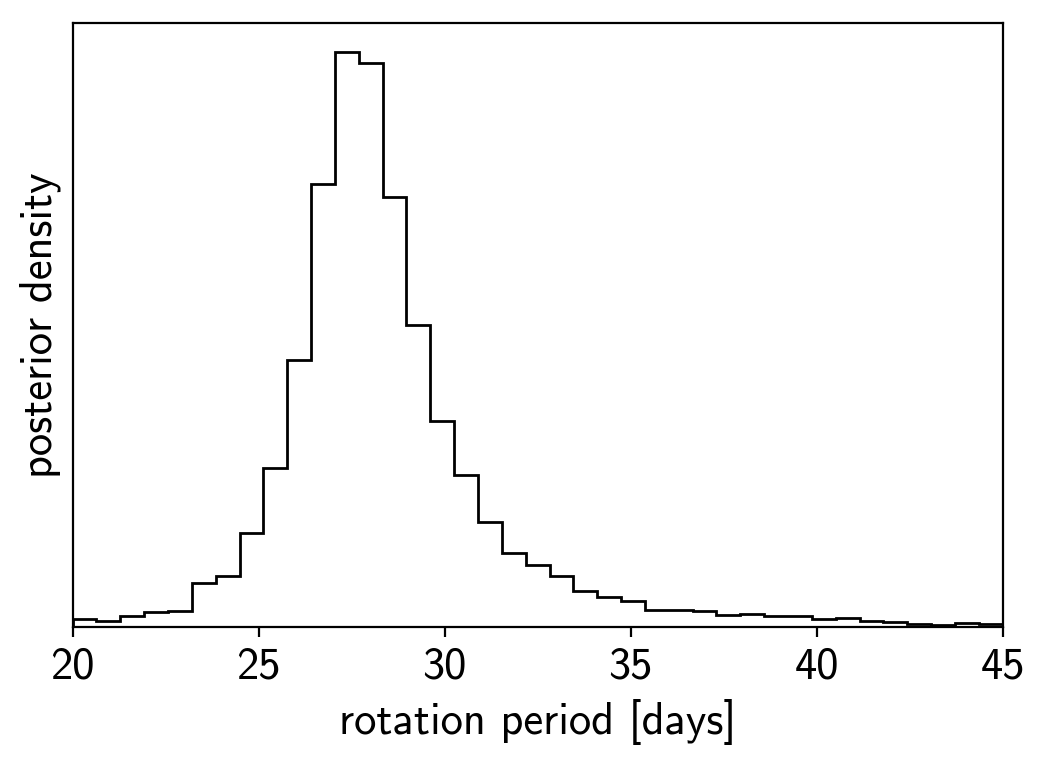

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
